## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Load a model

In [3]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames+hodnames

# Specify model configuration
nbody = 'mtnglike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [4]:
# Specify data dtype
tracer = 'ngc_lightcone'
summaries = ['Pk0', 'Pk2', 'Pk4']
summary = '+'.join(summaries)
kmax = 0.4
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
os.listdir(modelpath)

['x_val.npy',
 'posterior.pkl',
 'true_logprobs.npy',
 'ids_test.npy',
 'theta_train.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'nets',
 'plot_true_logprobs.jpg',
 'ids_train.npy',
 'theta_val.npy',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'x_train.npy',
 'plot_TARP.jpg',
 'plot_predictions.jpg',
 'ids_val.npy',
 'posterior_samples.npy']

In [15]:
# # Load training history
# summary_file = join(modelpath, 'summary.json')
# with open(summary_file, 'r') as f:
#     history = json.load(f)
# f, ax = plt.subplots(1, 1, figsize=(12, 4))
# for i in range(len(history)):
#     ax.plot(history[i]['training_log_probs'],
#             label=f'Training {i}', c=f'C{i}', ls='--')
#     ax.plot(history[i]['validation_log_probs'],
#             label=f'Validation {i}', c=f'C{i}')
# ax.set(xlabel='Epoch', ylabel='Log Probability')
# ax.legend()
# ax.set_ylim(-5, 15)

In [5]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

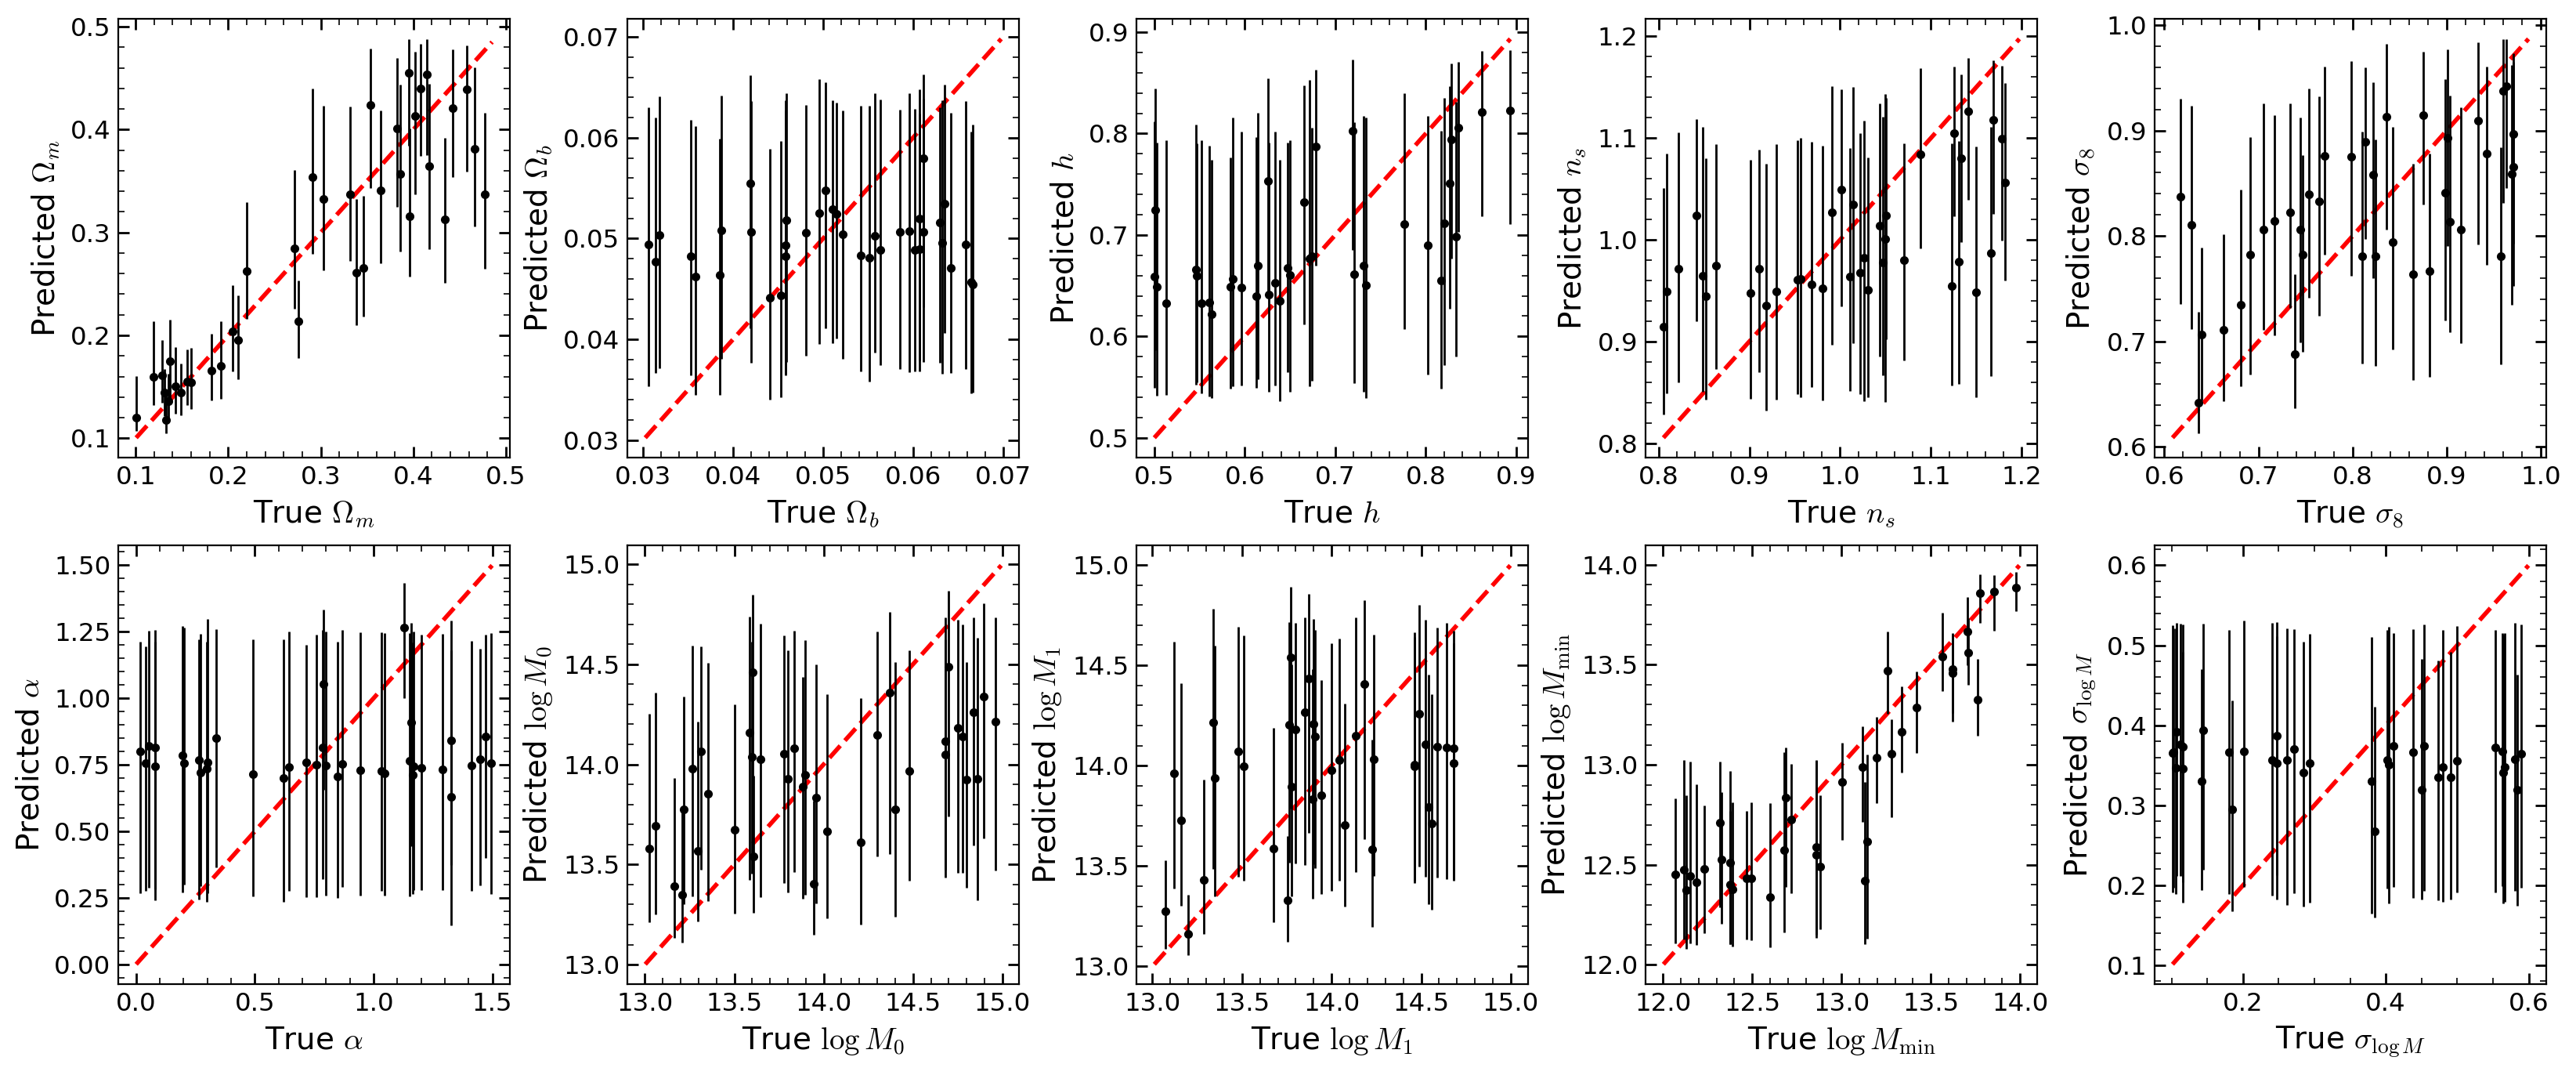

In [6]:

ss = 10

N = len(names)
f, axs = plt.subplots(2, N//2, figsize=(20, 8), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [18]:
# these functions load pickled torch modules
# if the model was trained on GPU, this will ensure safe loading to CPU
# TODO: update ltu-ili so this is already handled...

import torch
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_posterior(modeldir):
    with open(join(modeldir, 'posterior.pkl'), 'rb') as f:
        ensemble = CPU_Unpickler(f).load()
    ensemble = ensemble.to(device)
    for p in ensemble.posteriors:
        p.to(device)
    return ensemble


posterior = load_posterior(modelpath)

INFO:root:Sampling models with [448, 372, 271, 177, 166, 133, 117, 109, 109, 99] samples each.
Drawing 448 posterior samples: 765it [01:04, 11.83it/s]                         
Drawing 372 posterior samples: 699it [00:25, 27.96it/s]                         
Drawing 271 posterior samples: 483it [00:15, 31.03it/s]                         
Drawing 177 posterior samples: 263it [00:16, 16.37it/s]                         
Drawing 166 posterior samples: 291it [00:12, 23.92it/s]                         
Drawing 133 posterior samples: 195it [00:27,  7.06it/s]                         
Drawing 117 posterior samples: 190it [00:08, 21.15it/s]                         
Drawing 109 posterior samples: 145it [00:03, 44.06it/s]                        
Drawing 109 posterior samples: 147it [00:04, 36.56it/s]                        
Drawing 99 posterior samples: 172it [00:07, 23.16it/s]                       


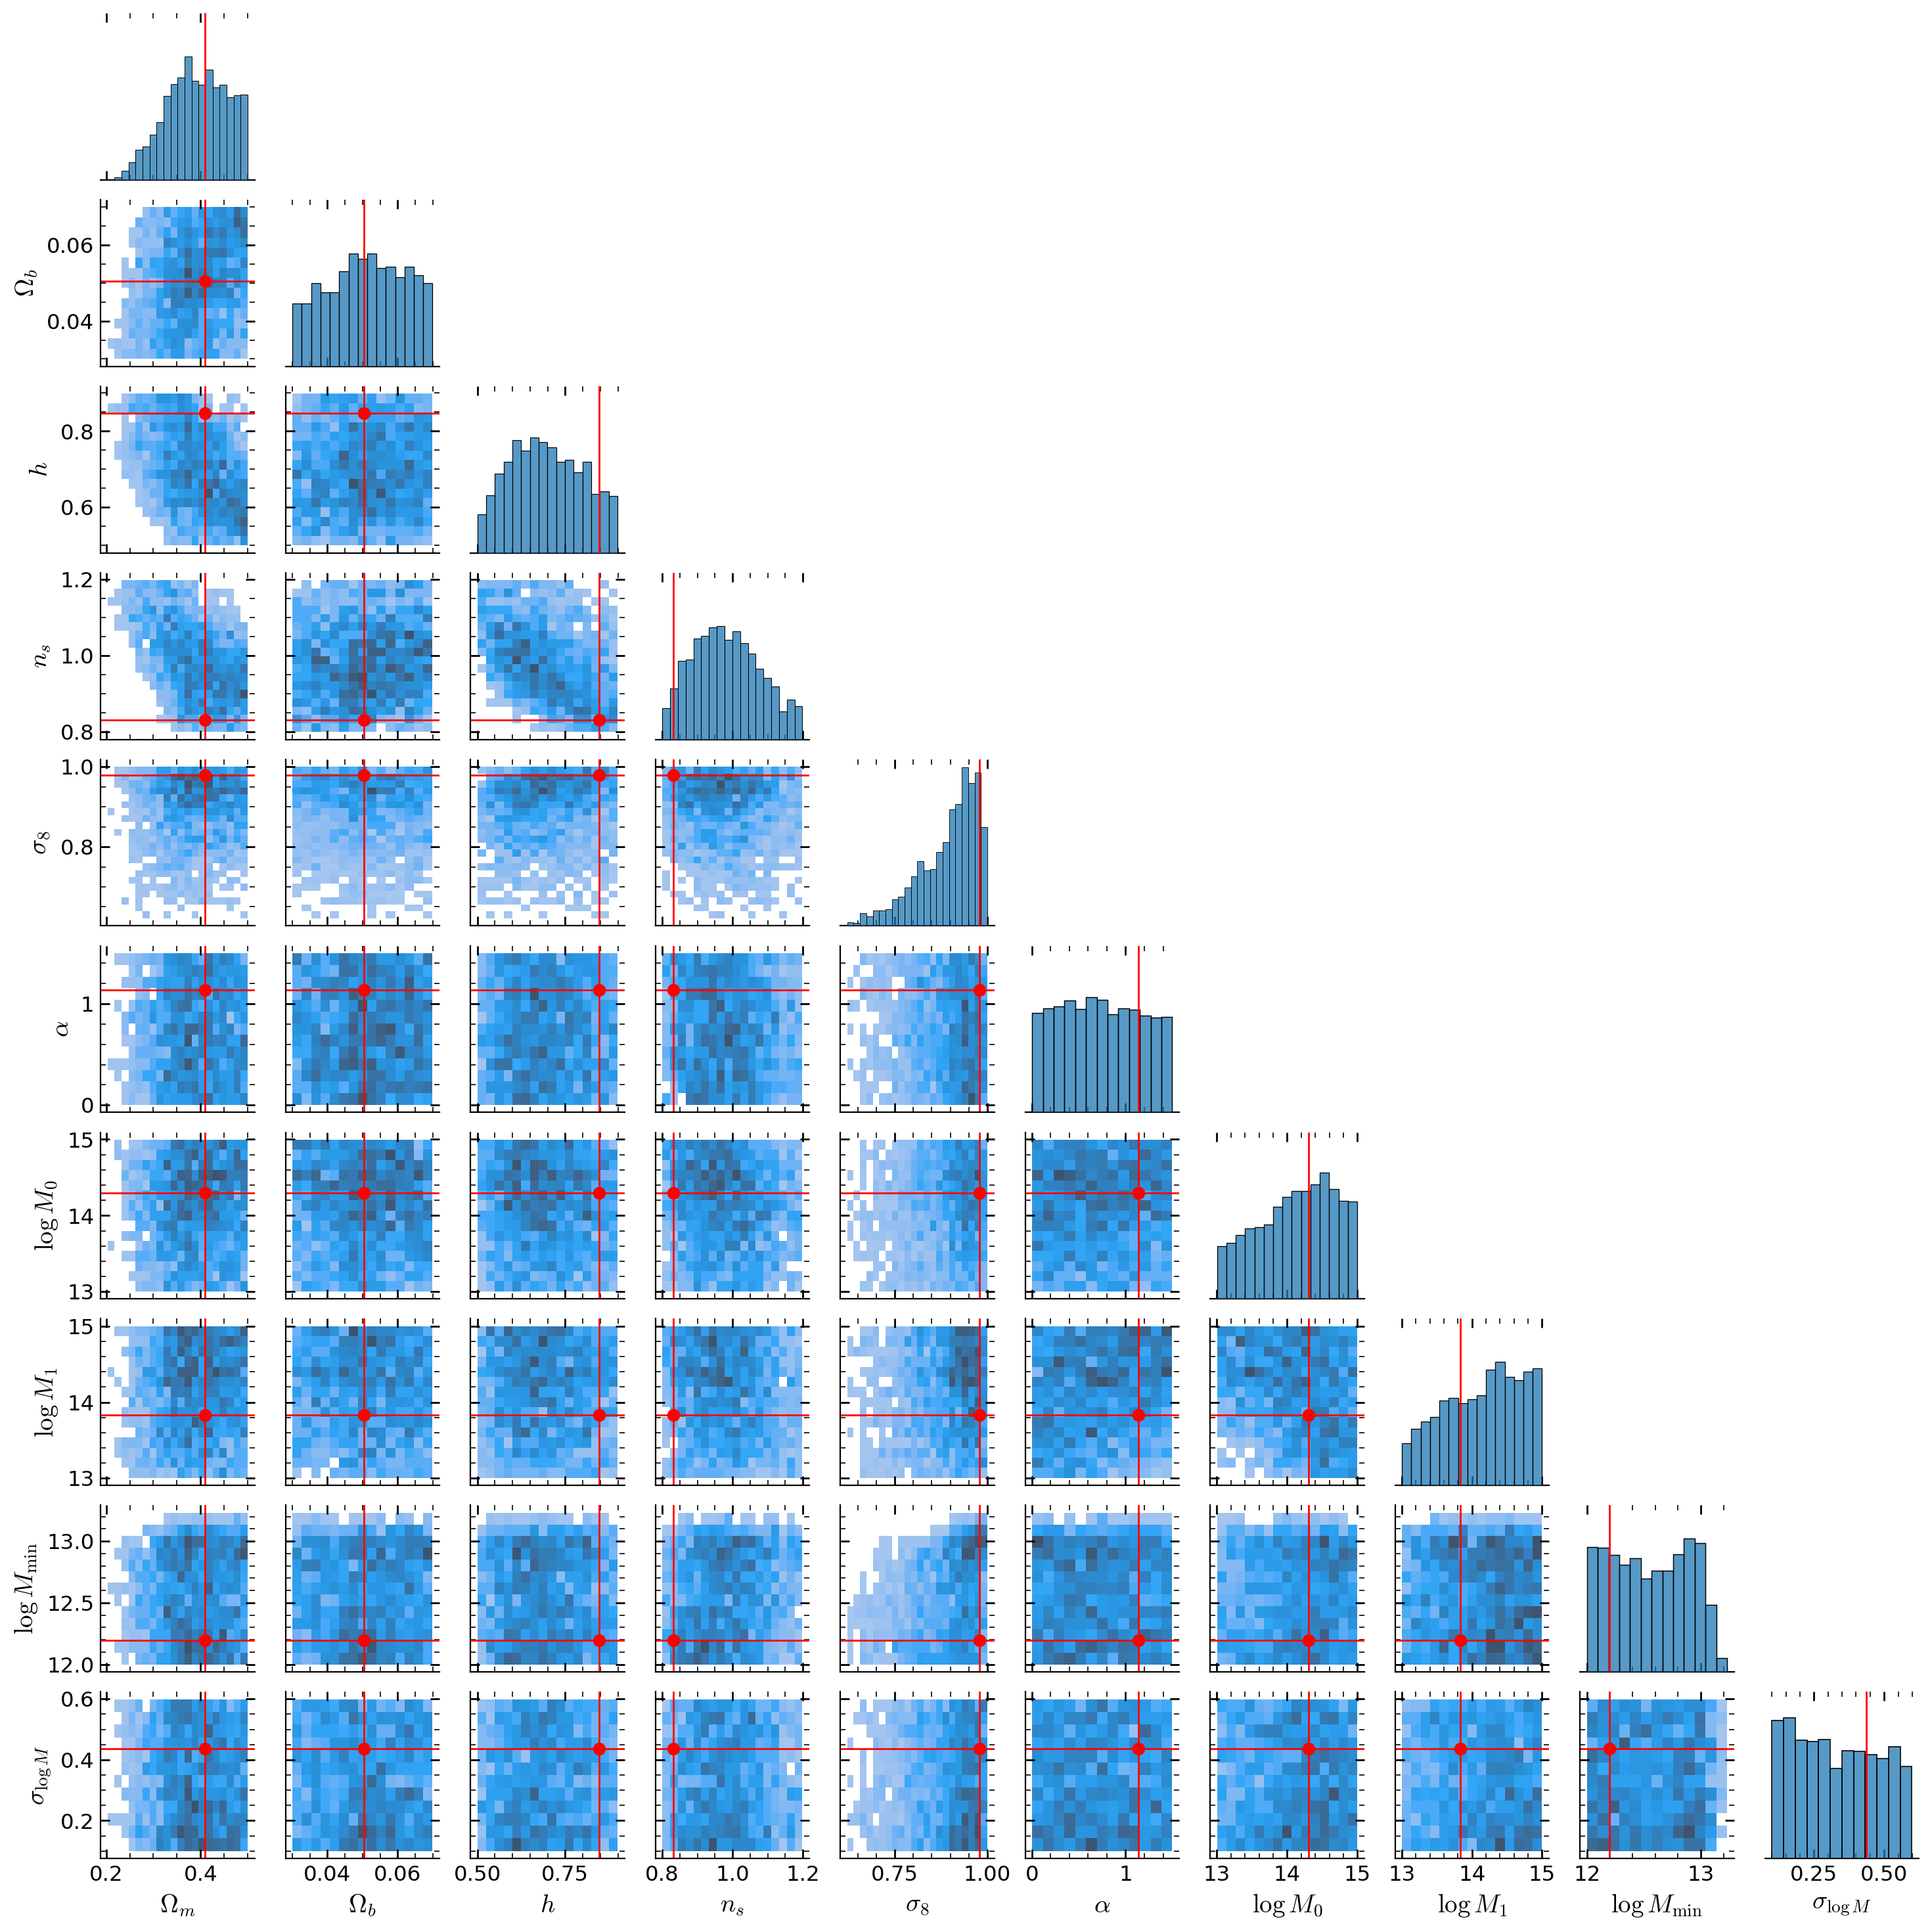

In [19]:
# Predict on a random test point
ind = 15
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)

## Load an observed summary

In [21]:
# Load an observed summary
nbody = 'quijote3gpch'
sim = 'nbody'
L, N = 3000, 384
lhid = 2000
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
with h5py.File(join(simpath, 'ngc_lightcone/hod20003_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]

    truecosmo = f.attrs['cosmo_params']
    truehod = f.attrs['HOD_params']
    trueparams = np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [22]:
trueparams

array([ 0.3175    ,  0.049     ,  0.6711    ,  0.9624    ,  0.834     ,
        1.04958903, 13.38268183, 14.21876213, 12.94525188,  0.14586841])

In [23]:
# Preprocess the summary
from cmass.infer.loaders import preprocess_Pk
xin = []
for s in summaries:
    if s == 'Pk0':
        xs = preprocess_Pk(summ[s], kmax, monopole=True)
    else:
        xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
    xin.append(xs)
xin = np.array(xin).flatten()

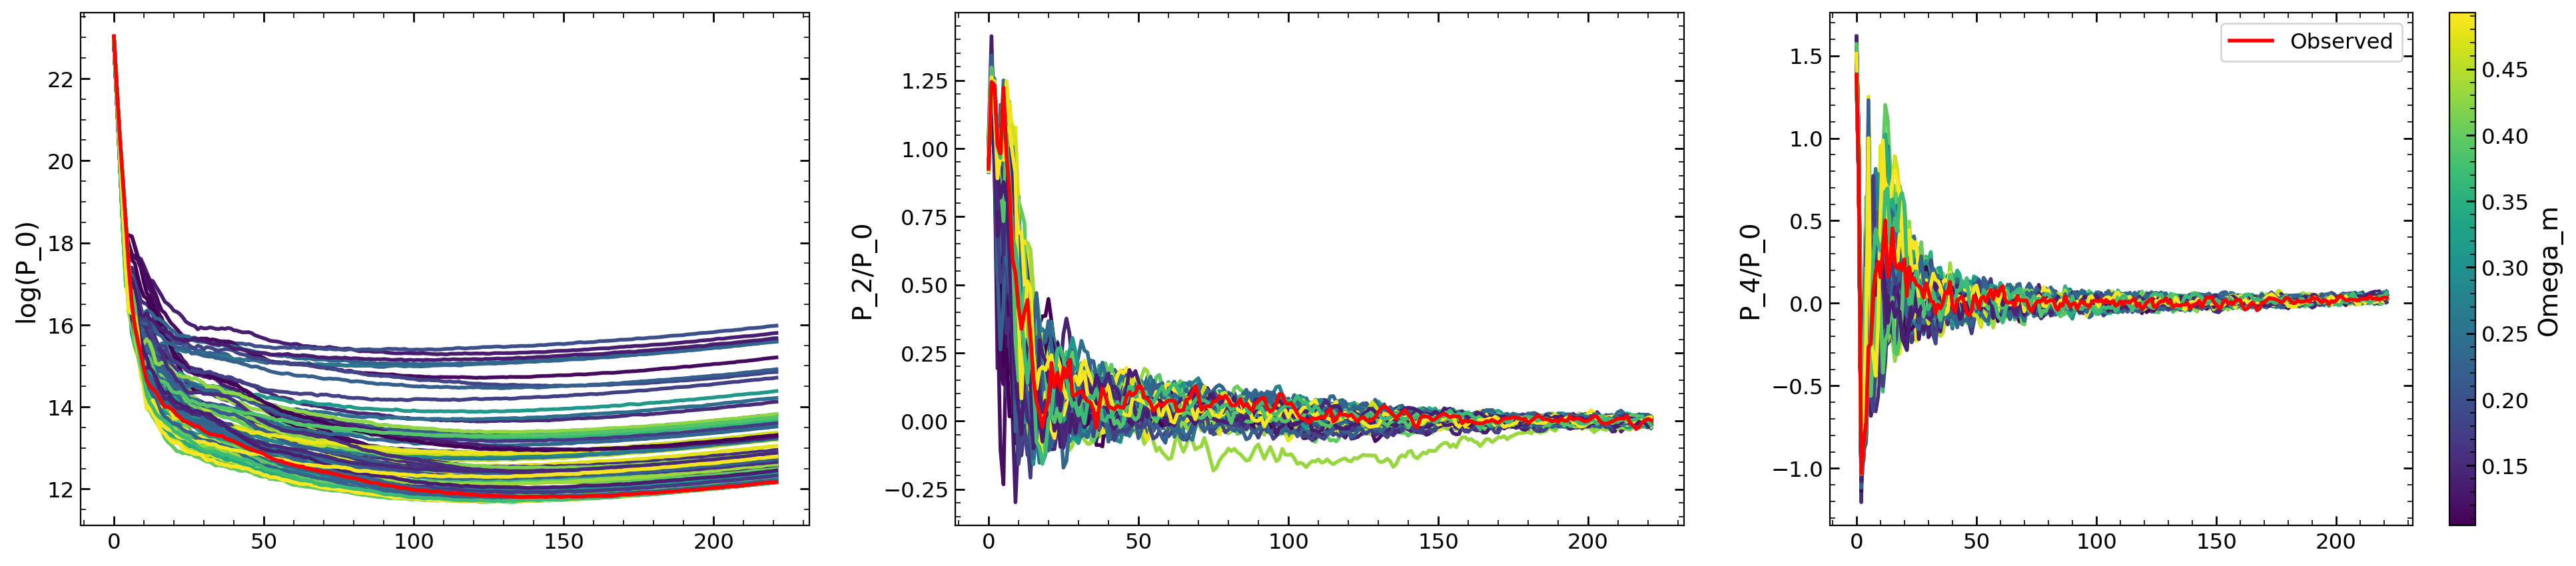

In [24]:
import matplotlib.colors as mcolors

ss = 10
Npoles = len(summaries)

f, axs = plt.subplots(1, Npoles, figsize=(8*Npoles, 5))
if Npoles == 1:
    axs = [axs]
par = ytest[::ss, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

for j, ax in enumerate(axs):
    for i, t in enumerate(xtest[::ss]):
        ax.plot(t.reshape(Npoles, -1)[j], color=cmap(norm(par[i])))
    ax.plot(xin.reshape(Npoles, -1)[j], color='r', label='Observed')
    if j == 0:
        ax.set_ylabel(f'log(P_{2*j})')
    else:
        ax.set_ylabel(f'P_{2*j}/P_0')

ax.legend()
plt.colorbar(plt.cm.ScalarMappable(
    cmap=cmap, norm=norm), ax=ax, label='Omega_m')

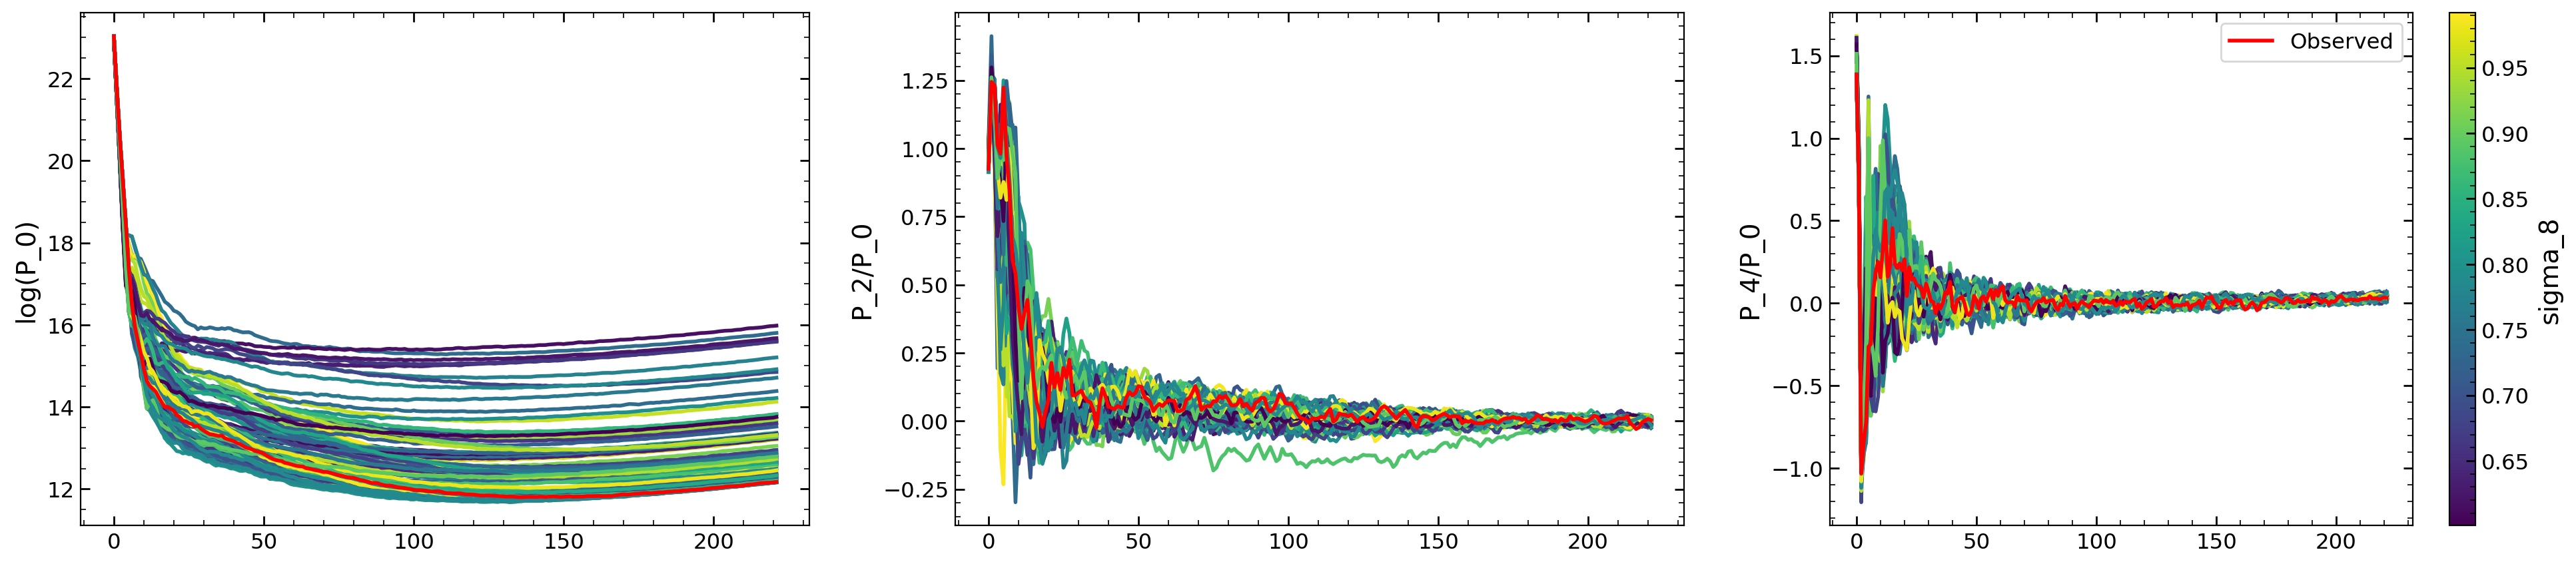

In [25]:
import matplotlib.colors as mcolors

ss = 10
Npoles = len(summaries)

f, axs = plt.subplots(1, Npoles, figsize=(8*Npoles, 5))
par = ytest[::ss, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

for j, ax in enumerate(axs):
    for i, t in enumerate(xtest[::ss]):
        ax.plot(t.reshape(Npoles, -1)[j], color=cmap(norm(par[i])))
    ax.plot(xin.reshape(Npoles, -1)[j], color='r', label='Observed')
    if j == 0:
        ax.set_ylabel(f'log(P_{2*j})')
    else:
        ax.set_ylabel(f'P_{2*j}/P_0')

ax.legend()
plt.colorbar(plt.cm.ScalarMappable(
    cmap=cmap, norm=norm), ax=ax, label='sigma_8')

INFO:root:Sampling models with [448, 372, 271, 177, 166, 133, 117, 109, 109, 99] samples each.
Drawing 448 posterior samples: 863it [00:02, 364.69it/s]                         
Drawing 372 posterior samples: 700it [00:00, 4826.21it/s]             
Drawing 271 posterior samples: 504it [00:00, 2892.40it/s]             
Drawing 177 posterior samples: 247it [00:18, 13.34it/s]                         
Drawing 166 posterior samples: 311it [00:12, 25.28it/s]                         
Drawing 133 posterior samples: 201it [00:19, 10.47it/s]                         
Drawing 117 posterior samples: 206it [00:08, 22.99it/s]                         
Drawing 109 posterior samples: 154it [00:03, 46.93it/s]                        
Drawing 109 posterior samples: 154it [00:00, 234.56it/s]                        
Drawing 99 posterior samples: 183it [00:02, 85.37it/s]                       


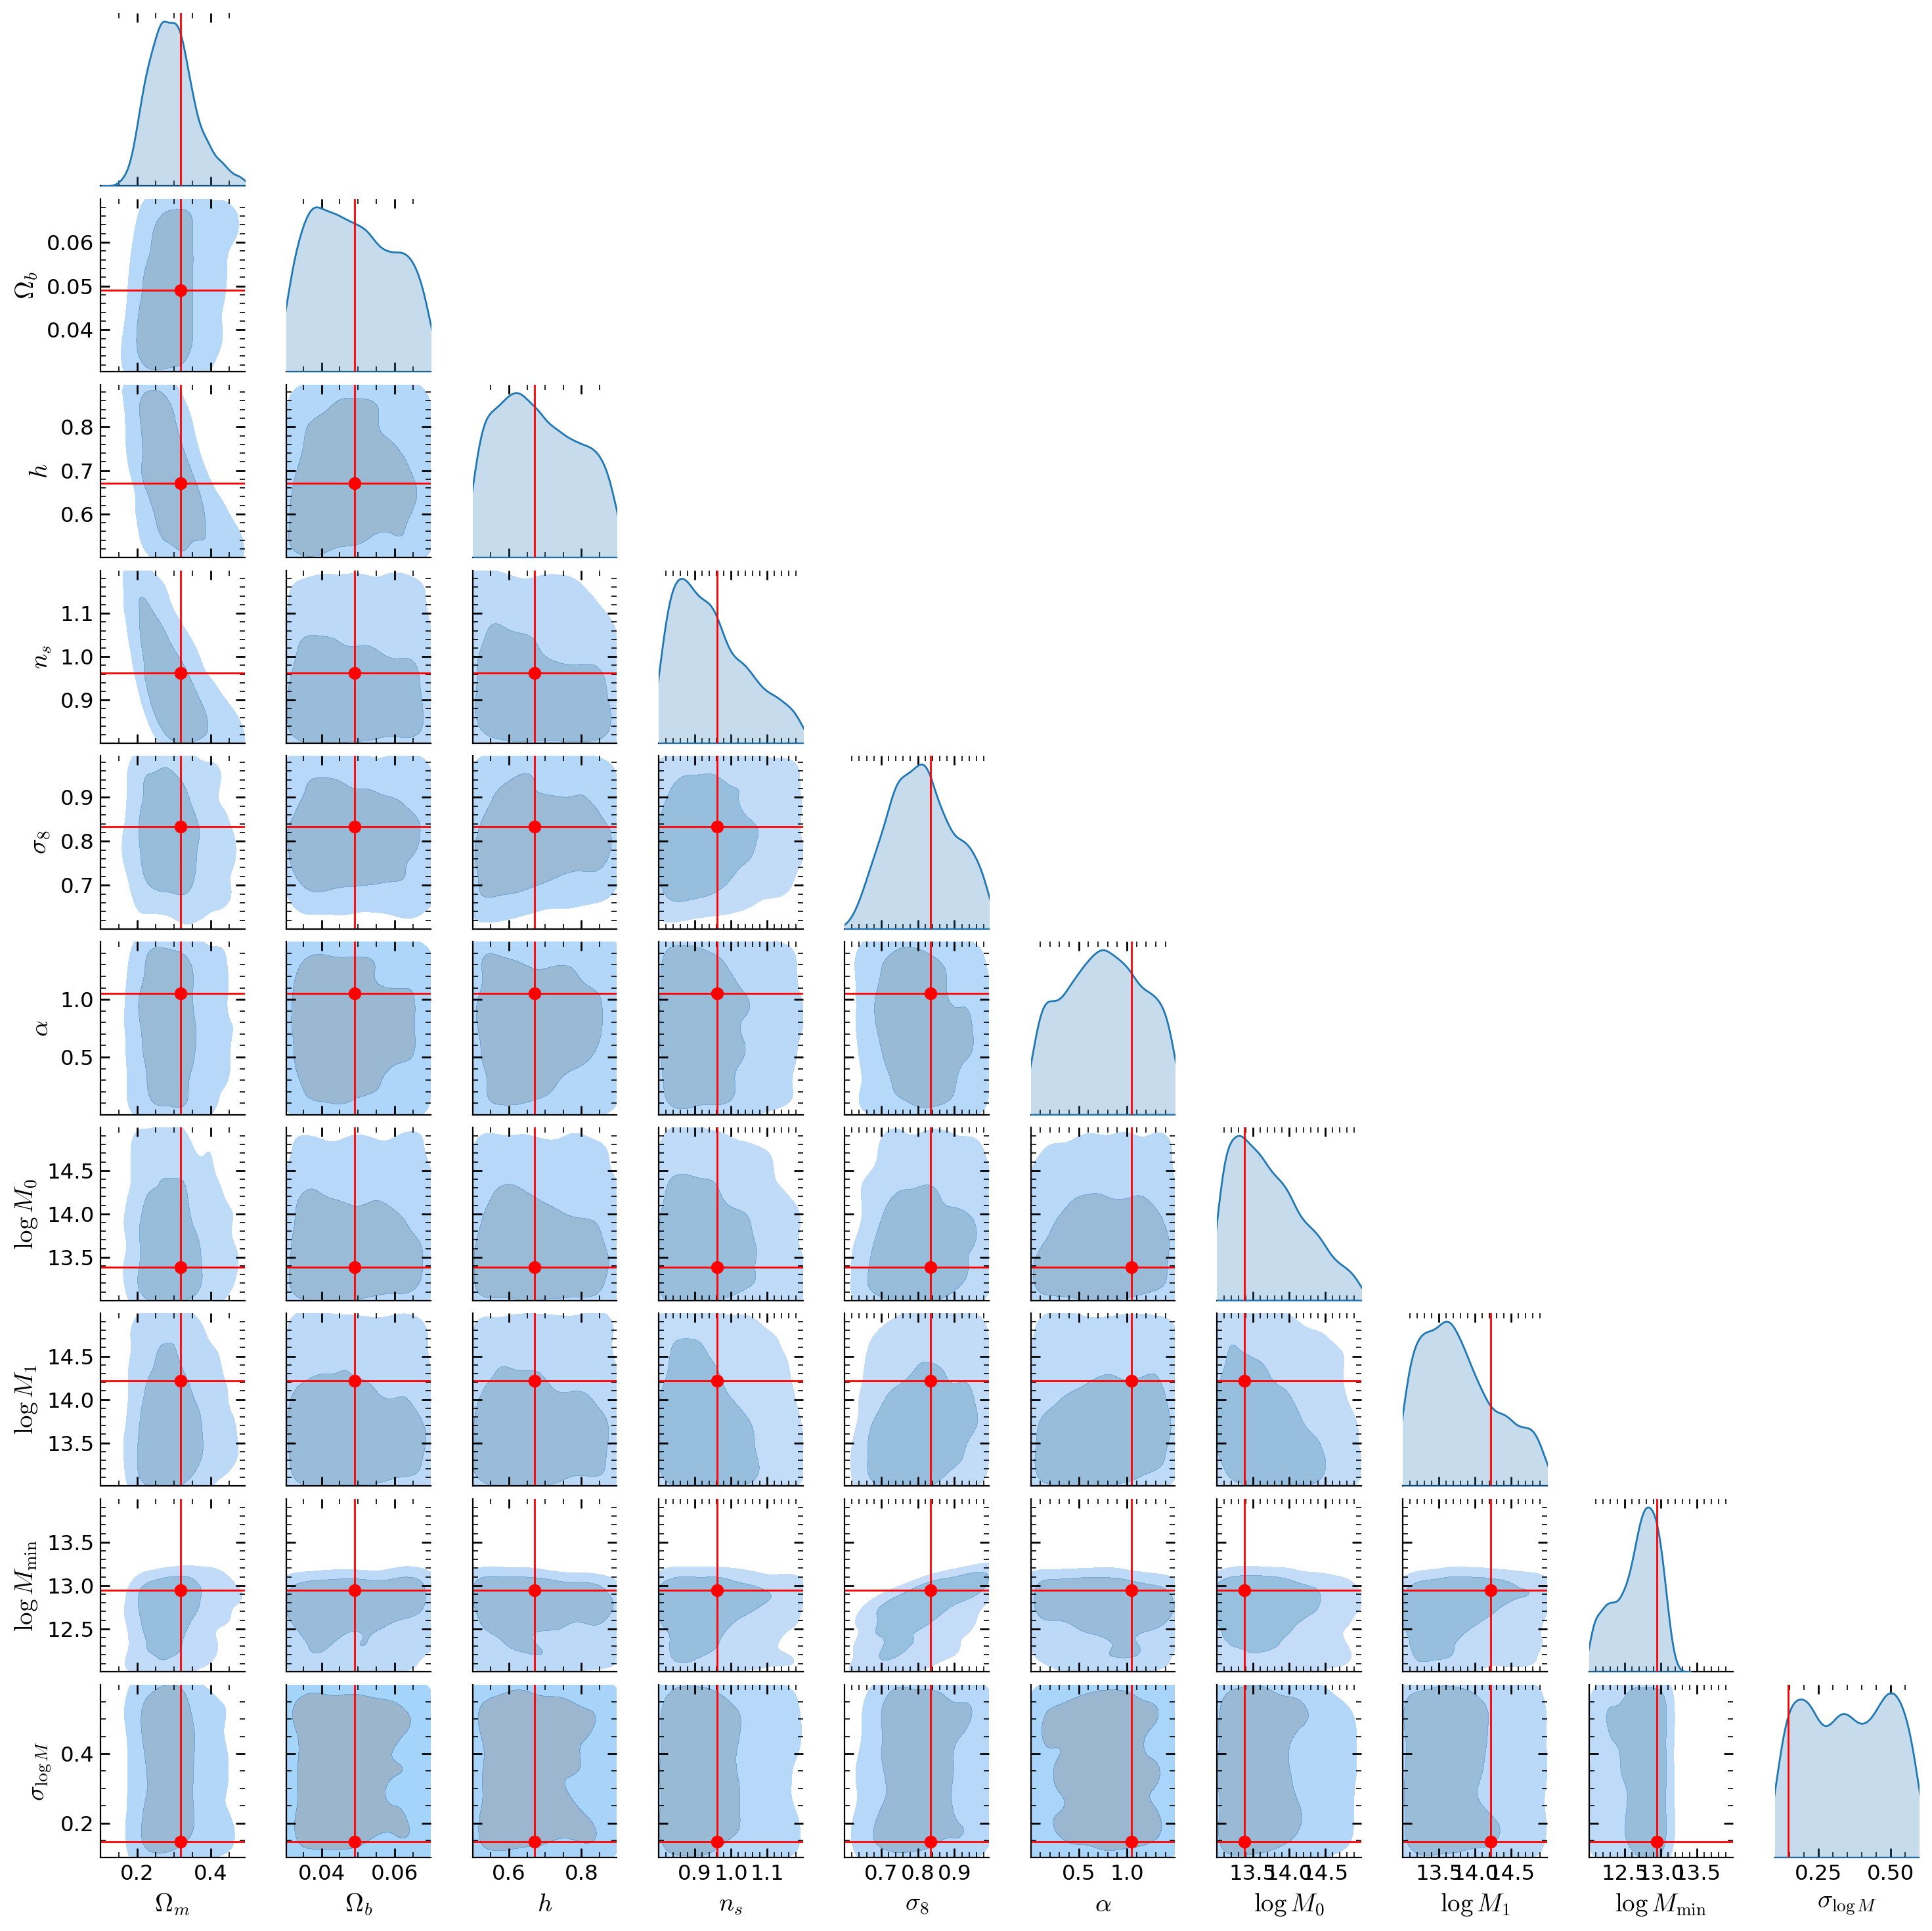

In [26]:
# Predict on a random test point
samp0 = posterior.sample(x=xin, shape=(2000,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


def set_boundaries(grid, prior_range):
    for i, (x, y) in enumerate(prior_range):
        grid.diag_axes[i].set_xlim(x, y)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.set_ylim(x, y)
                ax.set_xlim(*prior_range[j])


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, trueparams, color='r', lw=1)
set_boundaries(g, yrange)

In [27]:
# Load literature
import pandas as pd

# ivanov
iva = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/ivanov.csv')
iva = iva.drop('chain', axis=1)

# simbig
sbpk = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/simbig_pk.csv')


# our work
ltu = pd.DataFrame(samp0.values[:, :5], columns=iva.columns)

In [28]:
np.mean(sbpk.values[:, :], axis=0)

array([0.28747646, 0.04364681, 0.71466066, 0.93398812, 0.80653615])

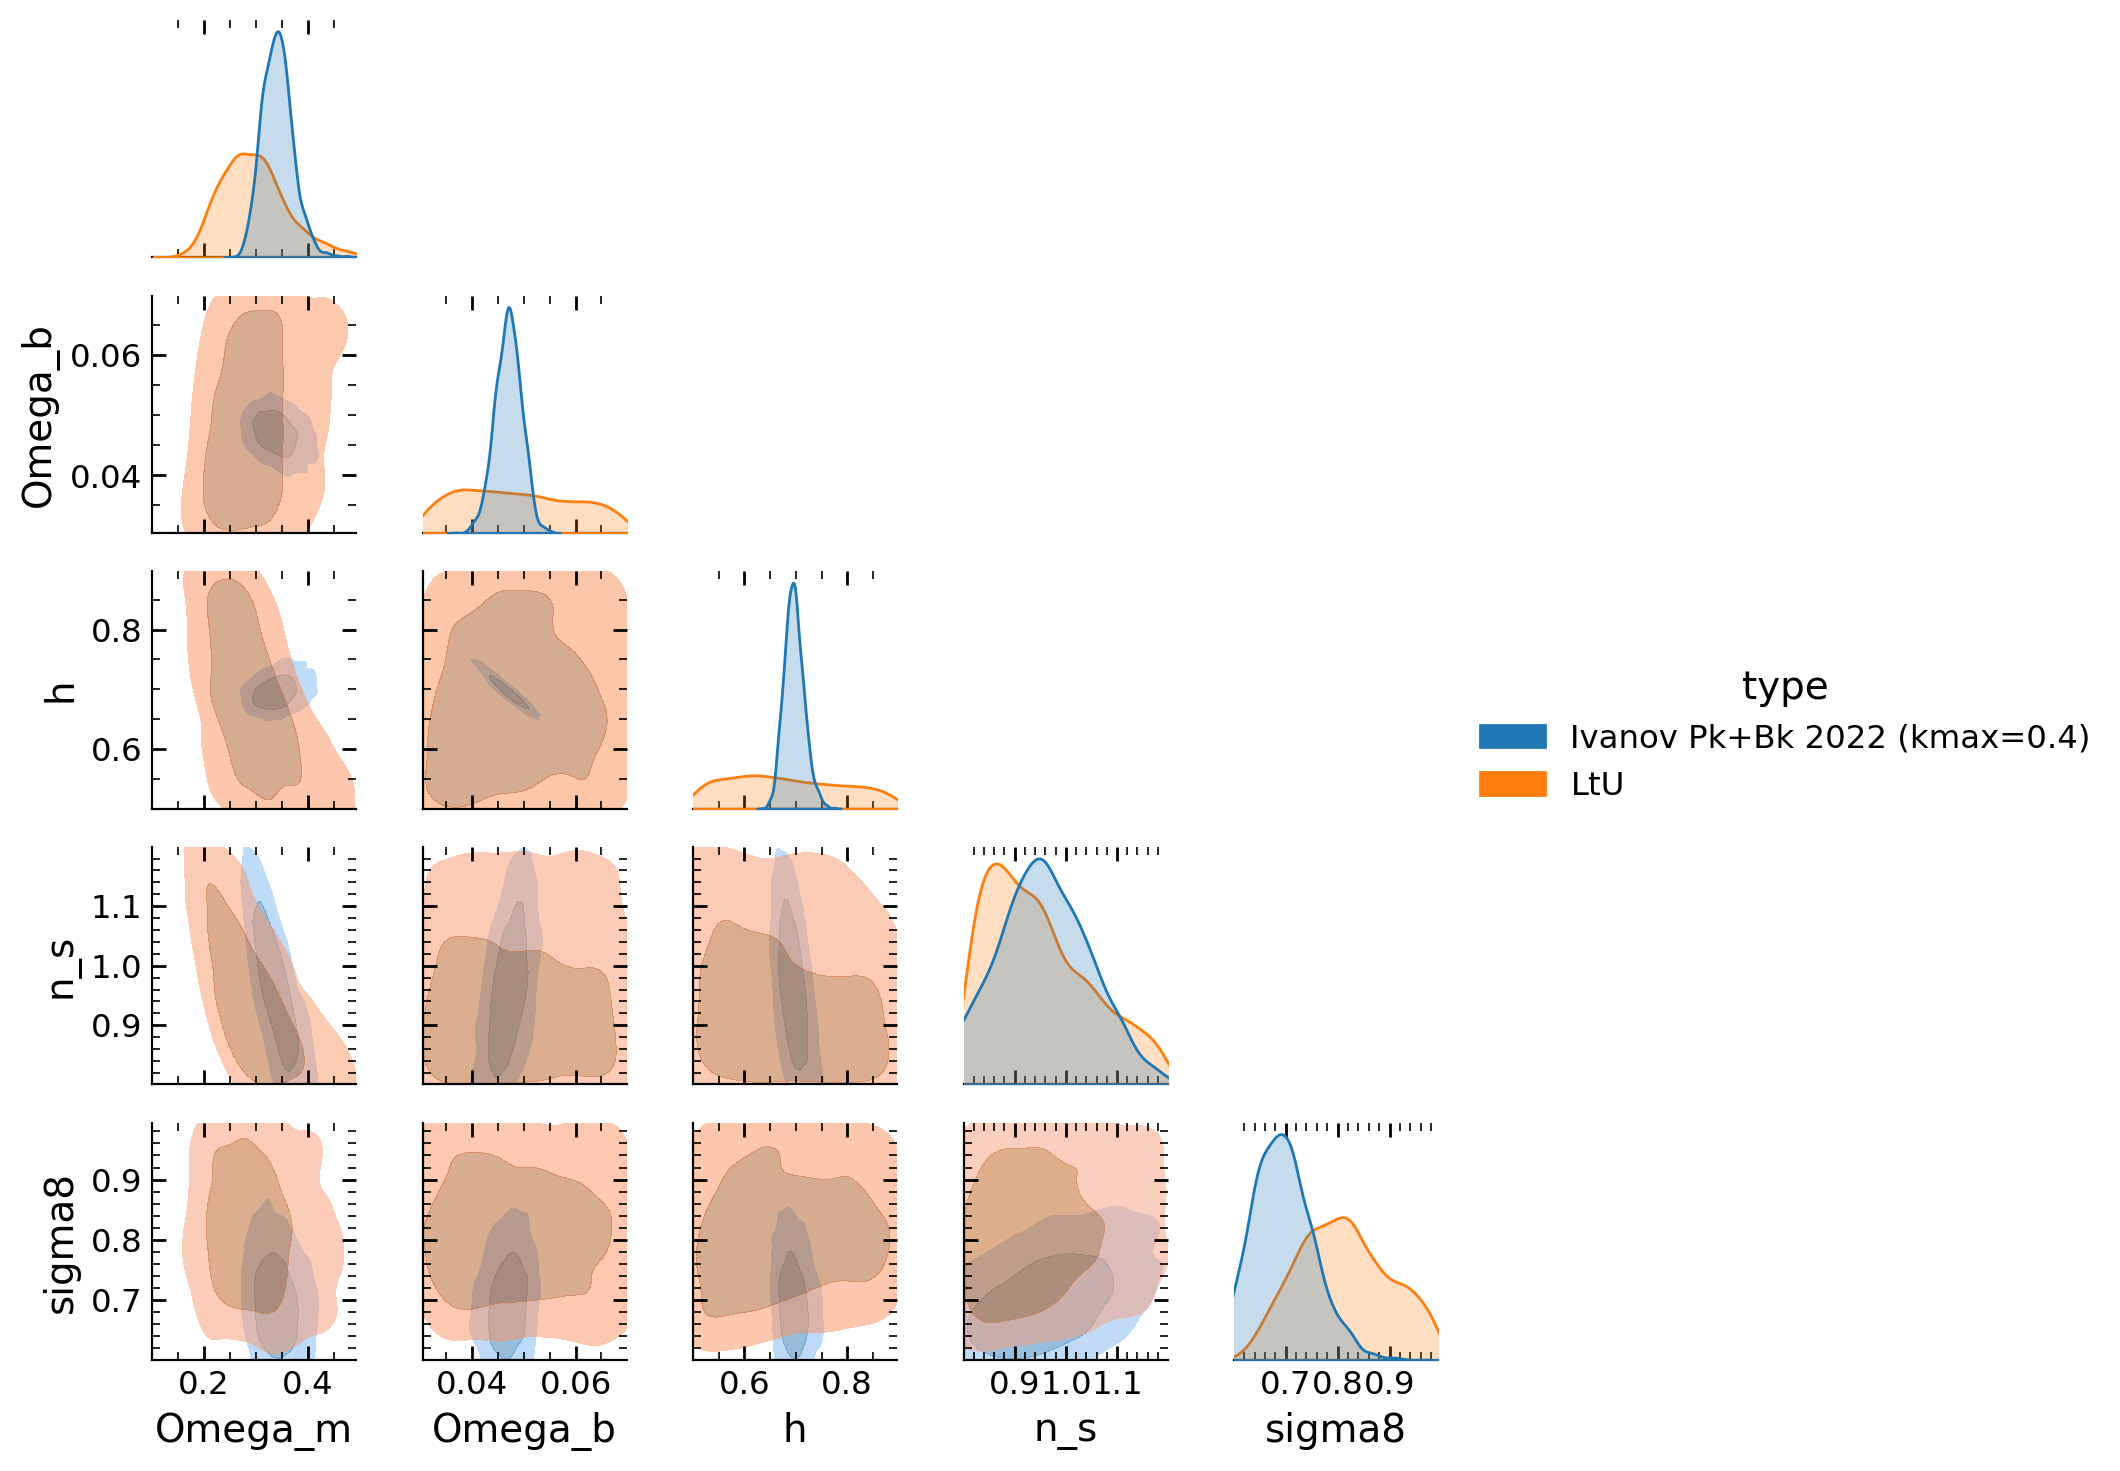

In [29]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([iva[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

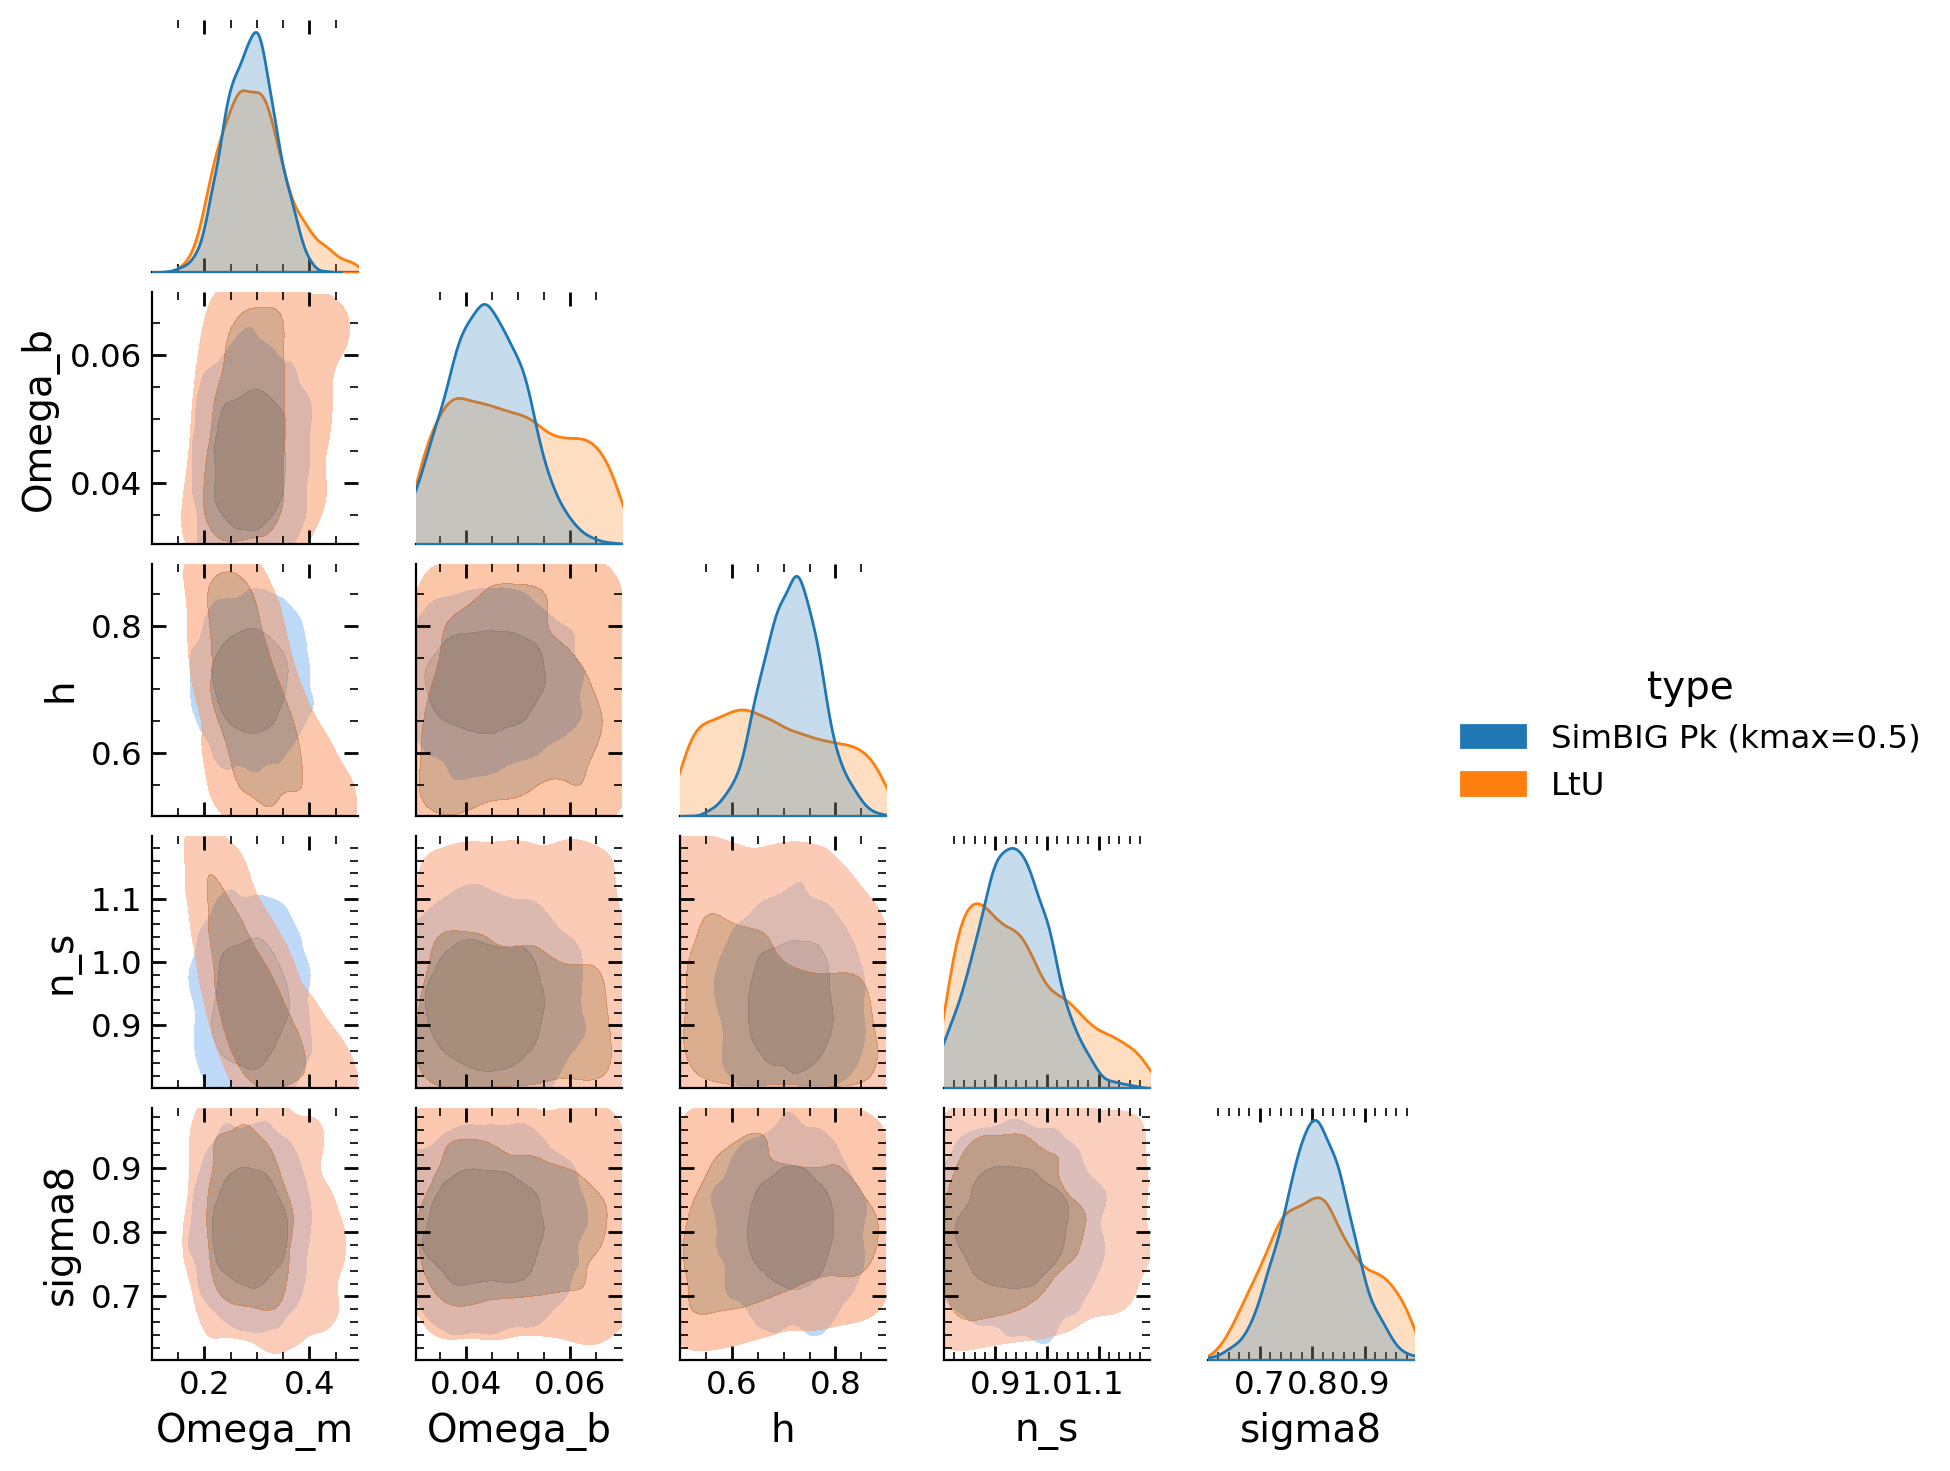

In [30]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([sbpk[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

## Predict across many

In [40]:
summaries = ['Pk0', 'Pk2', 'Pk4']
tracer = 'ngc_lightcone'

In [41]:
# Load an observed summary
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
with h5py.File(join(simpath, 'ngc_lightcone/hod06633_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]
# a=f'{2/3:.6f}'
# with h5py.File(join(simpath, 'galaxies/hod20003.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     truehod = f.attrs['HOD_params']
#     trueparams = np.concatenate([truecosmo, truehod])
# with h5py.File(join(simpath, 'halos.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     # truehod = f.attrs['HOD_params']
#     trueparams = truecosmo # np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [44]:
from cmass.infer.loaders import preprocess_Pk


def load_and_predict(summaries=['Pk0', 'Pk2'], kmax=0.1):
    # Specify data dtype
    summary = '+'.join(summaries)
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
    print(modelpath)

    # Load model posterior
    p = load_posterior(modelpath)

    # Load losses
    summary_file = join(modelpath, 'summary.json')
    if os.path.exists(summary_file):
        with open(summary_file, 'r') as f:
            history = json.load(f)
    else:
        history = None

    # Preprocess observations
    xin = []
    for s in summaries:
        if s == 'Pk0':
            xs = preprocess_Pk(summ[s], kmax, monopole=True)
        else:
            xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
        xin.append(xs)
    xin = np.array(xin).flatten()
    print(xin.shape)

    # Predict
    sampobs = p.sample(x=xin, shape=(1000,)).to('cpu')
    return sampobs, history

INFO:root:Sampling models with [192, 165, 149, 84, 76, 73, 69, 68, 63, 62] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.1
(165,)


Drawing 192 posterior samples: 368it [00:11, 30.76it/s]                         
Drawing 165 posterior samples: 304it [00:13, 22.01it/s]                         
Drawing 149 posterior samples: 283it [00:09, 28.87it/s]                         
Drawing 84 posterior samples: 131it [00:03, 40.00it/s]                       
Drawing 76 posterior samples: 136it [00:00, 1099.19it/s]            
Drawing 73 posterior samples: 118it [00:00, 2829.26it/s]            
Drawing 69 posterior samples: 86it [00:00, 1903.46it/s]             
Drawing 68 posterior samples: 114it [00:00, 2414.28it/s]            
Drawing 63 posterior samples: 121it [00:00, 3801.44it/s]            
Drawing 62 posterior samples: 111it [00:00, 1776.24it/s]            


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.2


INFO:root:Sampling models with [239, 198, 118, 76, 76, 73, 57, 55, 55, 53] samples each.


(330,)


Drawing 239 posterior samples: 459it [00:00, 3568.27it/s]             
Drawing 198 posterior samples: 375it [00:00, 2686.76it/s]             
Drawing 118 posterior samples: 228it [00:00, 2695.89it/s]             
Drawing 76 posterior samples: 84it [00:00, 23154.68it/s]            
Drawing 76 posterior samples: 133it [00:00, 4455.54it/s]            
Drawing 73 posterior samples: 134it [00:00, 1431.53it/s]            
Drawing 57 posterior samples: 109it [00:00, 1453.50it/s]            
Drawing 55 posterior samples: 63it [00:00, 2138.74it/s]             
Drawing 55 posterior samples: 82it [00:00, 1856.57it/s]             
Drawing 53 posterior samples: 94it [00:00, 1230.39it/s]             
INFO:root:Sampling models with [223, 148, 139, 90, 85, 78, 64, 61, 58, 55] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.3
(498,)


Drawing 223 posterior samples: 429it [00:00, 3380.72it/s]             
Drawing 148 posterior samples: 280it [00:00, 2949.72it/s]             
Drawing 139 posterior samples: 251it [00:00, 1997.73it/s]             
Drawing 90 posterior samples: 137it [00:00, 4268.27it/s]            
Drawing 85 posterior samples: 121it [00:00, 2382.44it/s]            
Drawing 78 posterior samples: 140it [00:00, 1460.75it/s]            
Drawing 64 posterior samples: 92it [00:00, 3079.91it/s]             
Drawing 61 posterior samples: 113it [00:00, 1452.94it/s]            
Drawing 58 posterior samples: 86it [00:00, 3605.95it/s]             
Drawing 55 posterior samples: 69it [00:00, 2092.09it/s]             
INFO:root:Sampling models with [224, 186, 136, 88, 83, 66, 58, 55, 55, 49] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 224 posterior samples: 418it [00:00, 3279.66it/s]             
Drawing 186 posterior samples: 355it [00:00, 3500.29it/s]             
Drawing 136 posterior samples: 256it [00:00, 2048.18it/s]             
Drawing 88 posterior samples: 131it [00:00, 4136.55it/s]            
Drawing 83 posterior samples: 144it [00:00, 1447.88it/s]            
Drawing 66 posterior samples: 92it [00:00, 3052.70it/s]             
Drawing 58 posterior samples: 105it [00:00, 1385.86it/s]            
Drawing 55 posterior samples: 91it [00:00, 3119.49it/s]             
Drawing 55 posterior samples: 74it [00:00, 2105.77it/s]             
Drawing 49 posterior samples: 84it [00:00, 1425.17it/s]             
INFO:root:Sampling models with [163, 150, 146, 116, 81, 78, 70, 67, 65, 64] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.5
(834,)


Drawing 163 posterior samples: 297it [00:00, 3148.18it/s]             
Drawing 150 posterior samples: 271it [00:00, 2445.26it/s]             
Drawing 146 posterior samples: 269it [00:00, 2064.27it/s]             
Drawing 116 posterior samples: 220it [00:00, 2144.91it/s]             
Drawing 81 posterior samples: 117it [00:00, 2376.86it/s]            
Drawing 78 posterior samples: 120it [00:00, 3734.94it/s]            
Drawing 70 posterior samples: 105it [00:00, 3277.02it/s]            
Drawing 67 posterior samples: 121it [00:00, 1962.46it/s]            
Drawing 65 posterior samples: 119it [00:00, 1548.73it/s]            
Drawing 64 posterior samples: 95it [00:00, 3977.75it/s]             


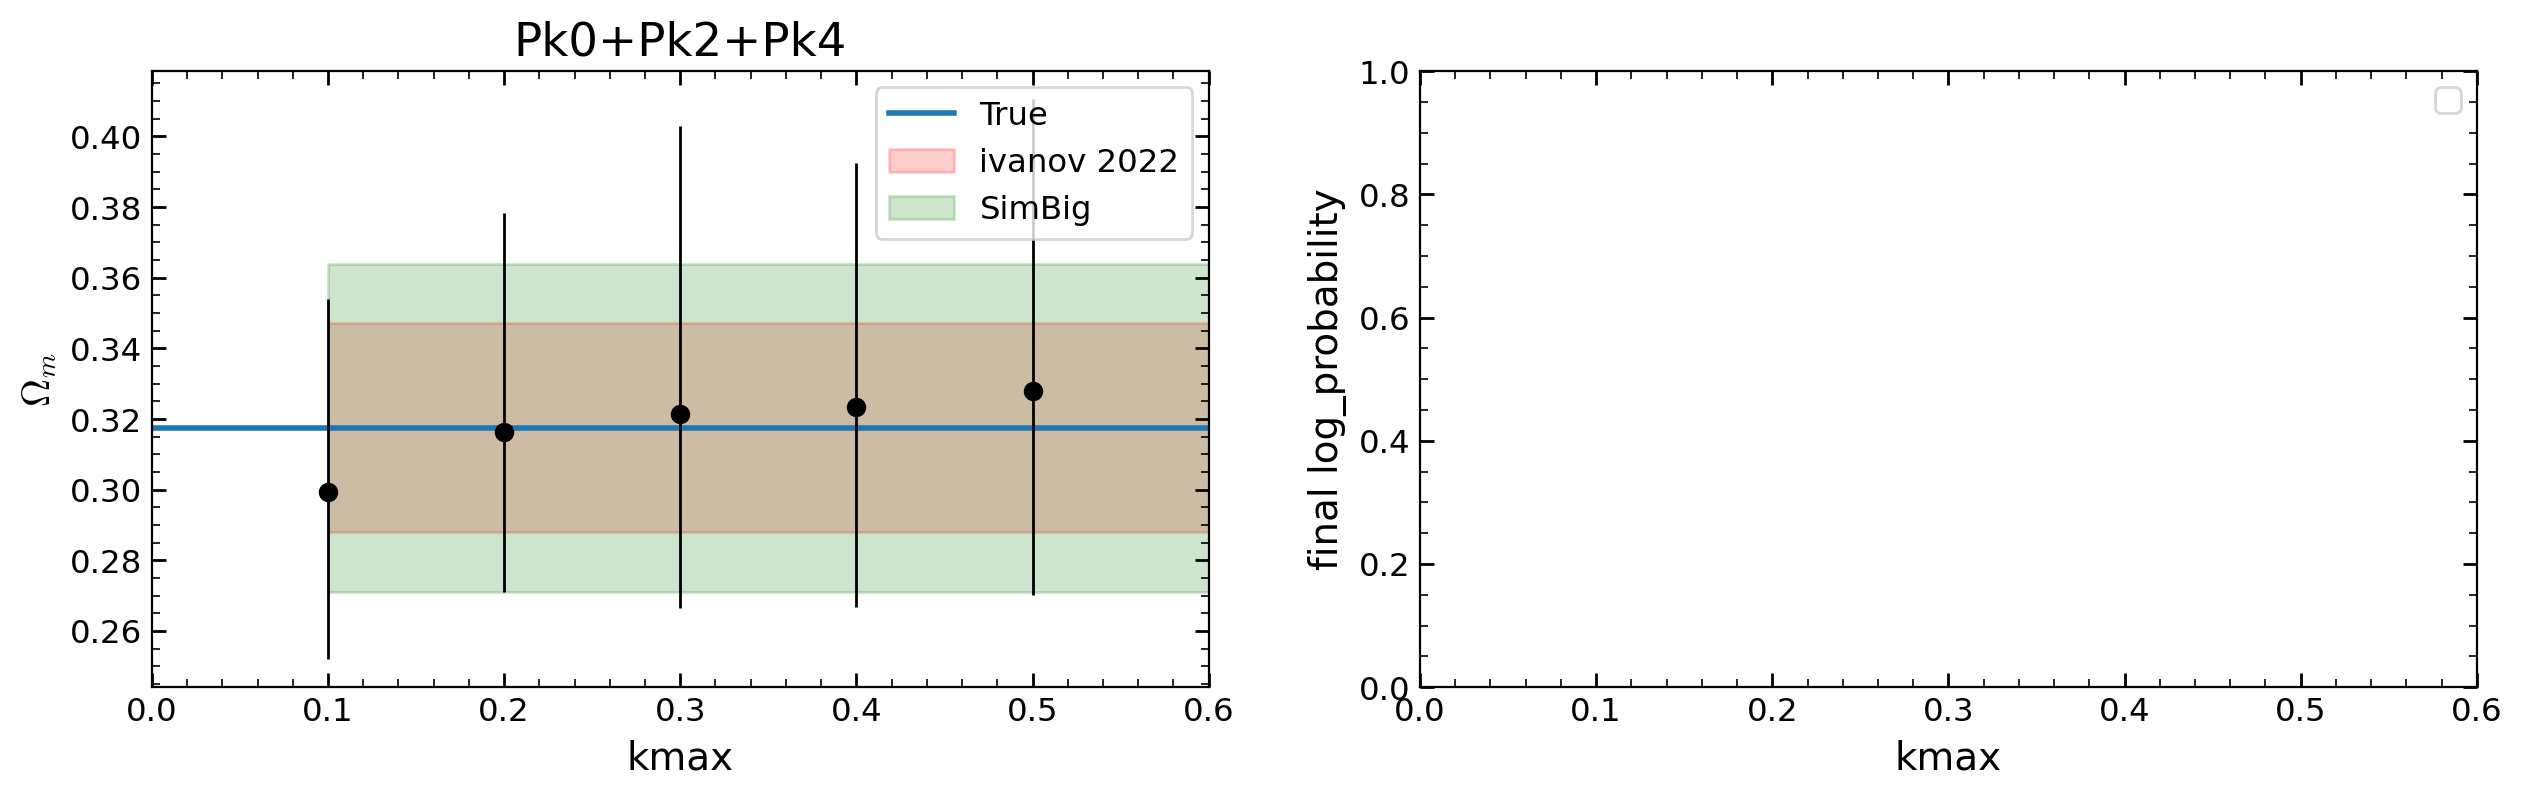

In [52]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.1, 0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # # plot losses
    # for j in range(len(hist)):
    #     ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
    #              label=f'Model {j}' if k == 0.2 else None,
    #              c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0., 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [192, 165, 149, 84, 76, 73, 69, 68, 63, 62] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.1
(165,)


Drawing 192 posterior samples: 365it [00:11, 30.77it/s]                         
Drawing 165 posterior samples: 308it [00:13, 22.09it/s]                         
Drawing 149 posterior samples: 287it [00:09, 28.82it/s]                         
Drawing 84 posterior samples: 135it [00:03, 41.00it/s]                       
Drawing 76 posterior samples: 136it [00:10, 13.07it/s]                       
Drawing 73 posterior samples: 117it [00:04, 25.13it/s]                       
Drawing 69 posterior samples: 93it [00:06, 13.86it/s]                        
Drawing 68 posterior samples: 110it [00:05, 20.63it/s]                       
Drawing 63 posterior samples: 120it [00:04, 24.67it/s]                       
Drawing 62 posterior samples: 111it [00:06, 16.14it/s]                       
INFO:root:Sampling models with [239, 198, 118, 76, 76, 73, 57, 55, 55, 53] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.2
(330,)


Drawing 239 posterior samples: 461it [00:13, 34.30it/s]                         
Drawing 198 posterior samples: 358it [00:13, 25.59it/s]                         
Drawing 118 posterior samples: 223it [00:08, 25.54it/s]                         
Drawing 76 posterior samples: 97it [00:00, 263.77it/s]                        
Drawing 76 posterior samples: 135it [00:03, 40.82it/s]                       
Drawing 73 posterior samples: 139it [00:10, 13.24it/s]                       
Drawing 57 posterior samples: 106it [00:08, 12.14it/s]                       
Drawing 55 posterior samples: 63it [00:04, 14.02it/s]                        
Drawing 55 posterior samples: 77it [00:05, 14.47it/s]                        
Drawing 53 posterior samples: 95it [00:08, 10.94it/s]                        
INFO:root:Sampling models with [223, 148, 139, 90, 85, 78, 64, 61, 58, 55] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.3
(498,)


Drawing 223 posterior samples: 429it [00:13, 31.39it/s]                         
Drawing 148 posterior samples: 275it [00:09, 27.94it/s]                         
Drawing 139 posterior samples: 240it [00:29,  8.05it/s]                         
Drawing 90 posterior samples: 148it [00:08, 17.92it/s]                       
Drawing 85 posterior samples: 122it [00:06, 19.67it/s]                       
Drawing 78 posterior samples: 142it [00:10, 13.63it/s]                       
Drawing 64 posterior samples: 98it [00:03, 29.74it/s]                        
Drawing 61 posterior samples: 113it [00:08, 13.05it/s]                       
Drawing 58 posterior samples: 91it [00:02, 34.77it/s]                        
Drawing 55 posterior samples: 80it [00:03, 20.24it/s]                        
INFO:root:Sampling models with [224, 186, 136, 88, 83, 66, 58, 55, 55, 49] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 224 posterior samples: 407it [00:13, 30.84it/s]                         
Drawing 186 posterior samples: 348it [00:09, 35.56it/s]                         
Drawing 136 posterior samples: 245it [00:12, 20.37it/s]                         
Drawing 88 posterior samples: 124it [00:03, 37.10it/s]                       
Drawing 83 posterior samples: 147it [00:10, 13.96it/s]                       
Drawing 66 posterior samples: 86it [00:03, 26.06it/s]                        
Drawing 58 posterior samples: 100it [00:08, 11.47it/s]                       
Drawing 55 posterior samples: 85it [00:03, 25.60it/s]                        
Drawing 55 posterior samples: 81it [00:03, 20.48it/s]                        
Drawing 49 posterior samples: 87it [00:06, 12.59it/s]                        
INFO:root:Sampling models with [163, 150, 146, 116, 81, 78, 70, 67, 65, 64] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.5
(834,)


Drawing 163 posterior samples: 295it [00:09, 29.82it/s]                         
Drawing 150 posterior samples: 274it [00:11, 23.06it/s]                         
Drawing 146 posterior samples: 262it [00:13, 18.76it/s]                         
Drawing 116 posterior samples: 214it [00:10, 20.51it/s]                         
Drawing 81 posterior samples: 121it [00:05, 22.79it/s]                       
Drawing 78 posterior samples: 121it [00:03, 36.75it/s]                       
Drawing 70 posterior samples: 96it [00:03, 29.12it/s]                        
Drawing 67 posterior samples: 116it [00:06, 16.77it/s]                       
Drawing 65 posterior samples: 112it [00:08, 12.90it/s]                       
Drawing 64 posterior samples: 90it [00:02, 34.39it/s]                        


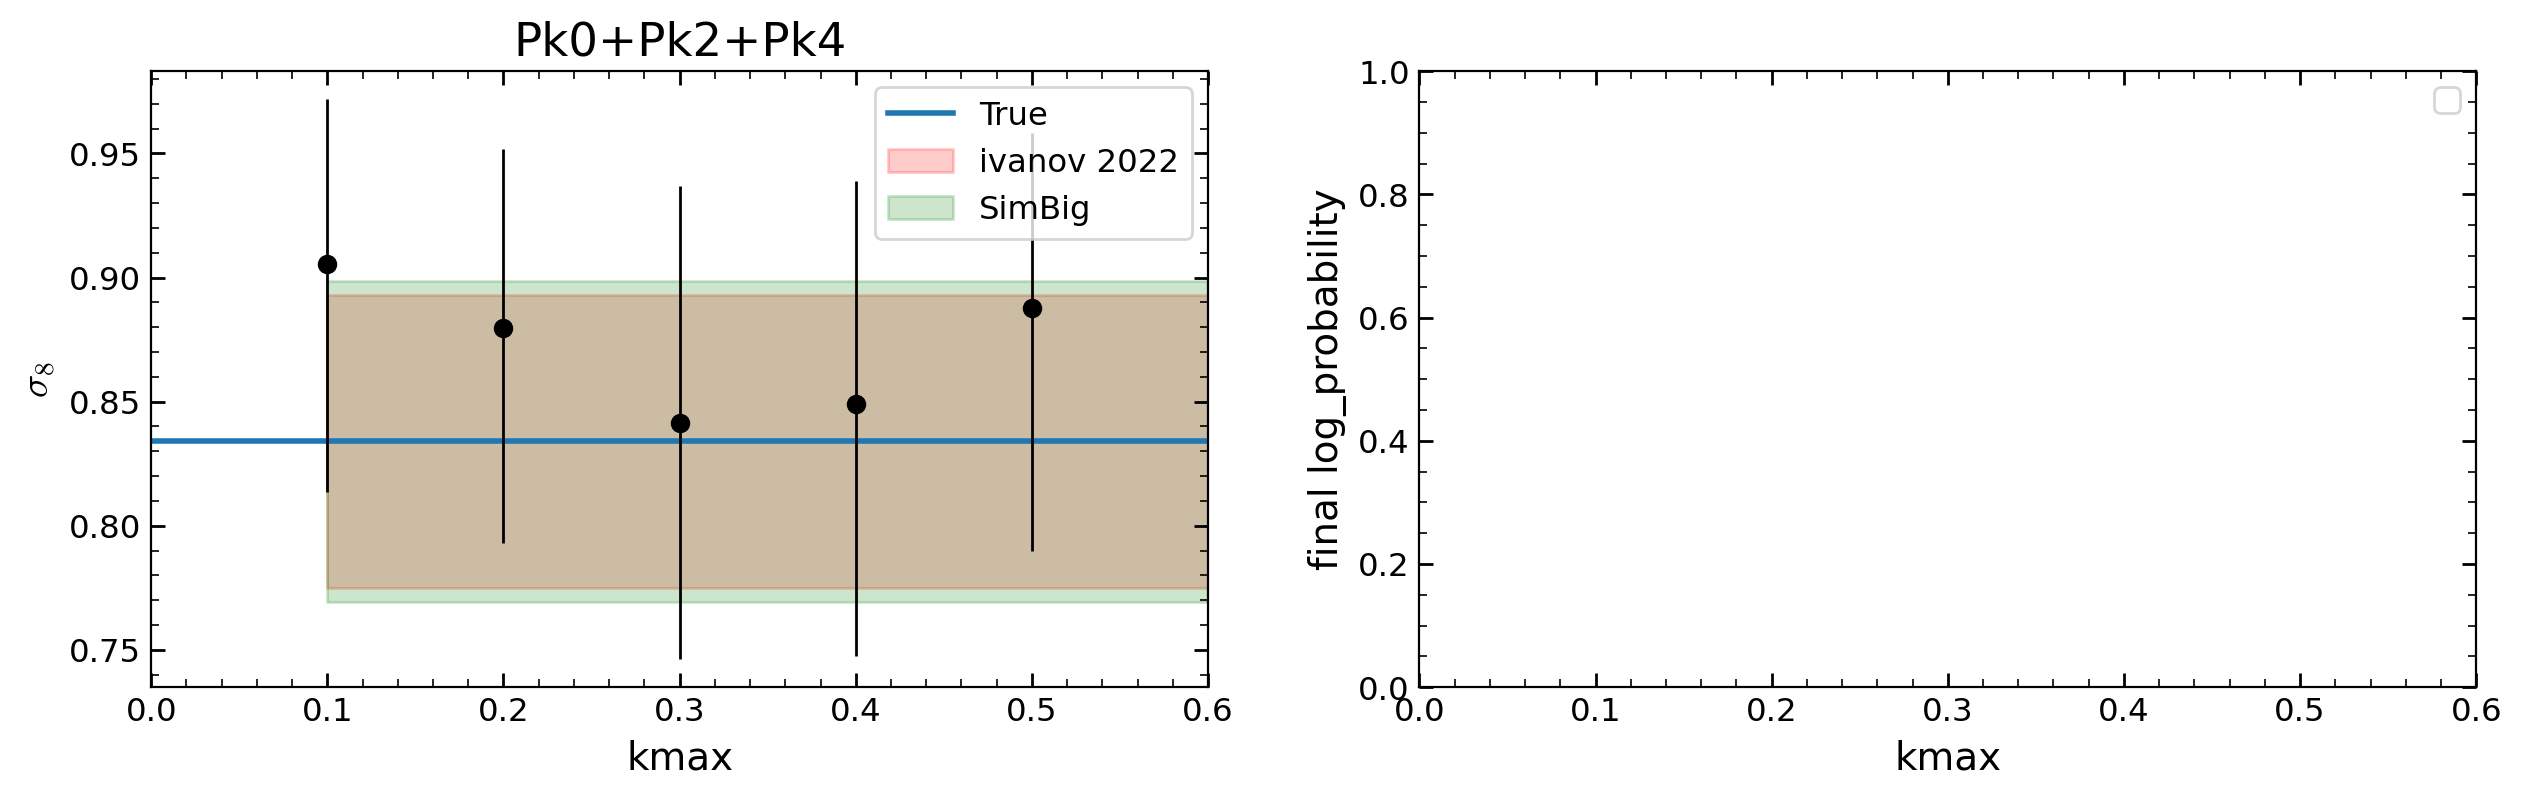

In [51]:
# sigma_8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.1, 0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # # plot losses
    # for j in range(len(hist)):
    #     ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
    #              label=f'Model {j}' if k == 0.2 else None,
    #              c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.0, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [239, 198, 118, 76, 76, 73, 57, 55, 55, 53] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.2
(330,)


Drawing 239 posterior samples: 459it [00:13, 34.34it/s]                         
Drawing 198 posterior samples: 360it [00:13, 25.99it/s]                         
Drawing 118 posterior samples: 225it [00:08, 25.98it/s]                         
Drawing 76 posterior samples: 79it [00:00, 215.10it/s]                        
Drawing 76 posterior samples: 123it [00:03, 37.30it/s]                       
Drawing 73 posterior samples: 131it [00:10, 12.60it/s]                       
Drawing 57 posterior samples: 103it [00:08, 11.83it/s]                       
Drawing 55 posterior samples: 61it [00:04, 13.65it/s]                        
Drawing 55 posterior samples: 71it [00:05, 13.38it/s]                        
Drawing 53 posterior samples: 100it [00:08, 11.46it/s]                       
INFO:root:Sampling models with [223, 148, 139, 90, 85, 78, 64, 61, 58, 55] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.3
(498,)


Drawing 223 posterior samples: 430it [00:13, 31.94it/s]                         
Drawing 148 posterior samples: 274it [00:09, 27.59it/s]                         
Drawing 139 posterior samples: 260it [00:12, 21.25it/s]                         
Drawing 90 posterior samples: 146it [00:03, 43.74it/s]                       
Drawing 85 posterior samples: 125it [00:05, 23.62it/s]                       
Drawing 78 posterior samples: 142it [00:10, 13.56it/s]                       
Drawing 64 posterior samples: 98it [00:03, 29.62it/s]                        
Drawing 61 posterior samples: 107it [00:08, 12.29it/s]                       
Drawing 58 posterior samples: 87it [00:02, 32.96it/s]                        
Drawing 55 posterior samples: 72it [00:03, 18.11it/s]                        
INFO:root:Sampling models with [224, 186, 136, 88, 83, 66, 58, 55, 55, 49] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 224 posterior samples: 413it [00:13, 30.71it/s]                         
Drawing 186 posterior samples: 350it [00:09, 35.06it/s]                         
Drawing 136 posterior samples: 251it [00:12, 20.56it/s]                         
Drawing 88 posterior samples: 133it [00:03, 40.17it/s]                       
Drawing 83 posterior samples: 152it [00:10, 14.54it/s]                       
Drawing 66 posterior samples: 91it [00:03, 27.51it/s]                        
Drawing 58 posterior samples: 112it [00:08, 12.85it/s]                       
Drawing 55 posterior samples: 85it [00:03, 25.77it/s]                        
Drawing 55 posterior samples: 77it [00:03, 19.53it/s]                        
Drawing 49 posterior samples: 87it [00:06, 12.52it/s]                        
INFO:root:Sampling models with [163, 150, 146, 116, 81, 78, 70, 67, 65, 64] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.5
(834,)


Drawing 163 posterior samples: 297it [00:09, 29.82it/s]                         
Drawing 150 posterior samples: 275it [00:11, 23.09it/s]                         
Drawing 146 posterior samples: 275it [00:13, 19.70it/s]                         
Drawing 116 posterior samples: 215it [00:10, 20.58it/s]                         
Drawing 81 posterior samples: 124it [00:05, 23.32it/s]                       
Drawing 78 posterior samples: 126it [00:03, 38.00it/s]                       
Drawing 70 posterior samples: 94it [00:03, 28.49it/s]                        
Drawing 67 posterior samples: 123it [00:06, 17.81it/s]                       
Drawing 65 posterior samples: 111it [00:08, 12.80it/s]                       
Drawing 64 posterior samples: 90it [00:02, 34.38it/s]                        


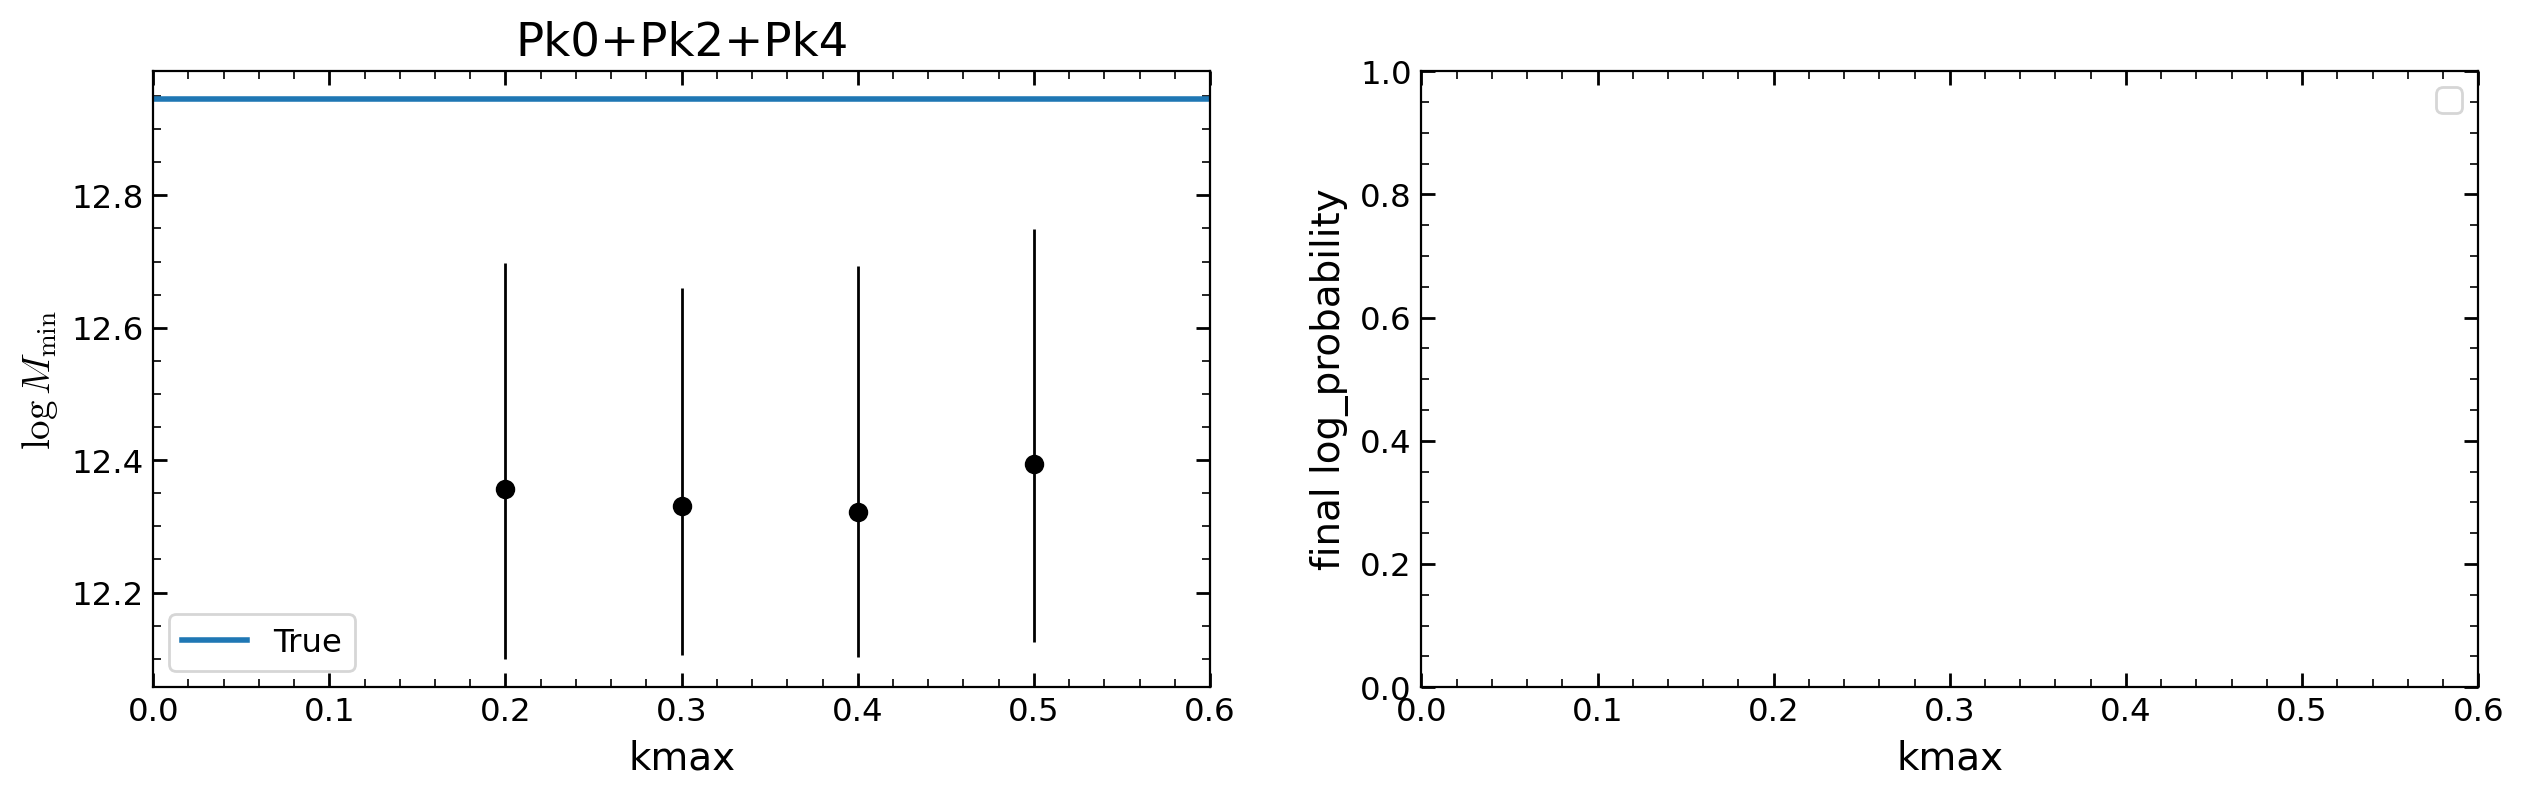

In [50]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.1, 0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    # for j in range(len(hist)):
    #     ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
    #              label=f'Model {j}' if k == 0.2 else None,
    #              c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.0, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

NameError: name 'trueparams' is not defined

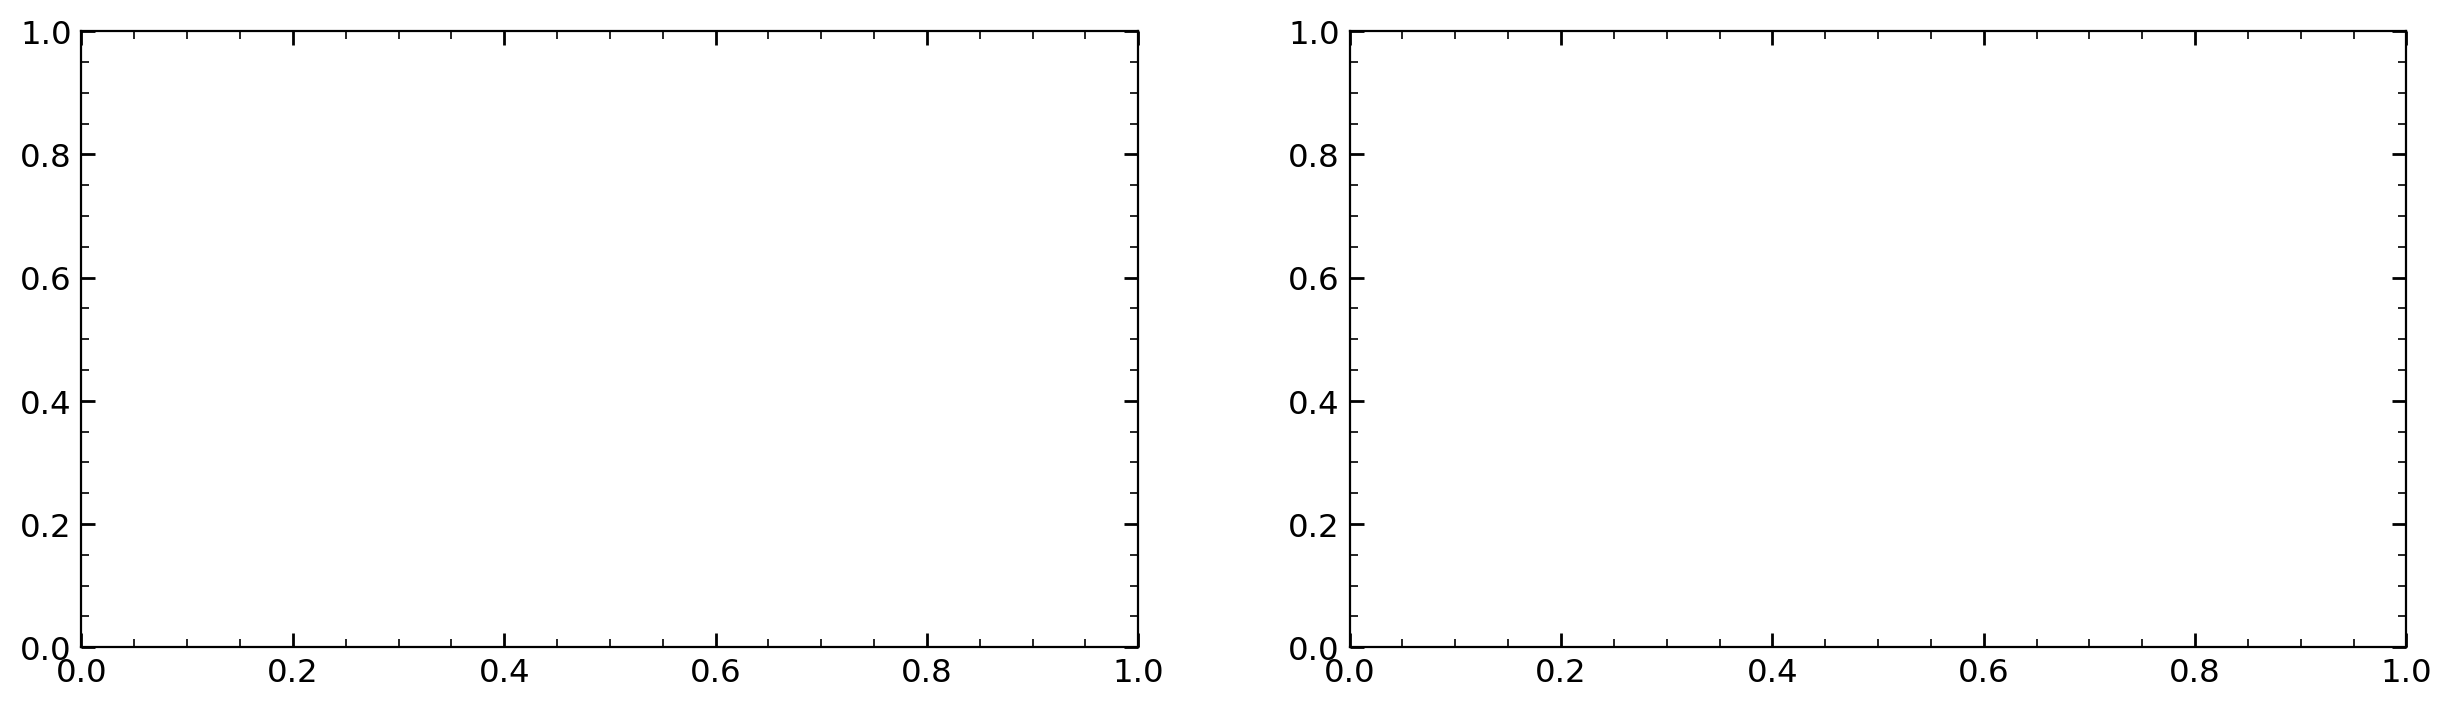

In [ ]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Qk0']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1372it [00:00, 8680.19it/s]            
Drawing 126 posterior samples: 128it [00:00, 3677.93it/s]             
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1714it [00:00, 10559.12it/s]           
Drawing 105 posterior samples: 136it [00:00, 3783.69it/s]             
INFO:root:Sampling models with [1000, 0] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 1000 posterior samples: 1674it [00:00, 9345.91it/s]             


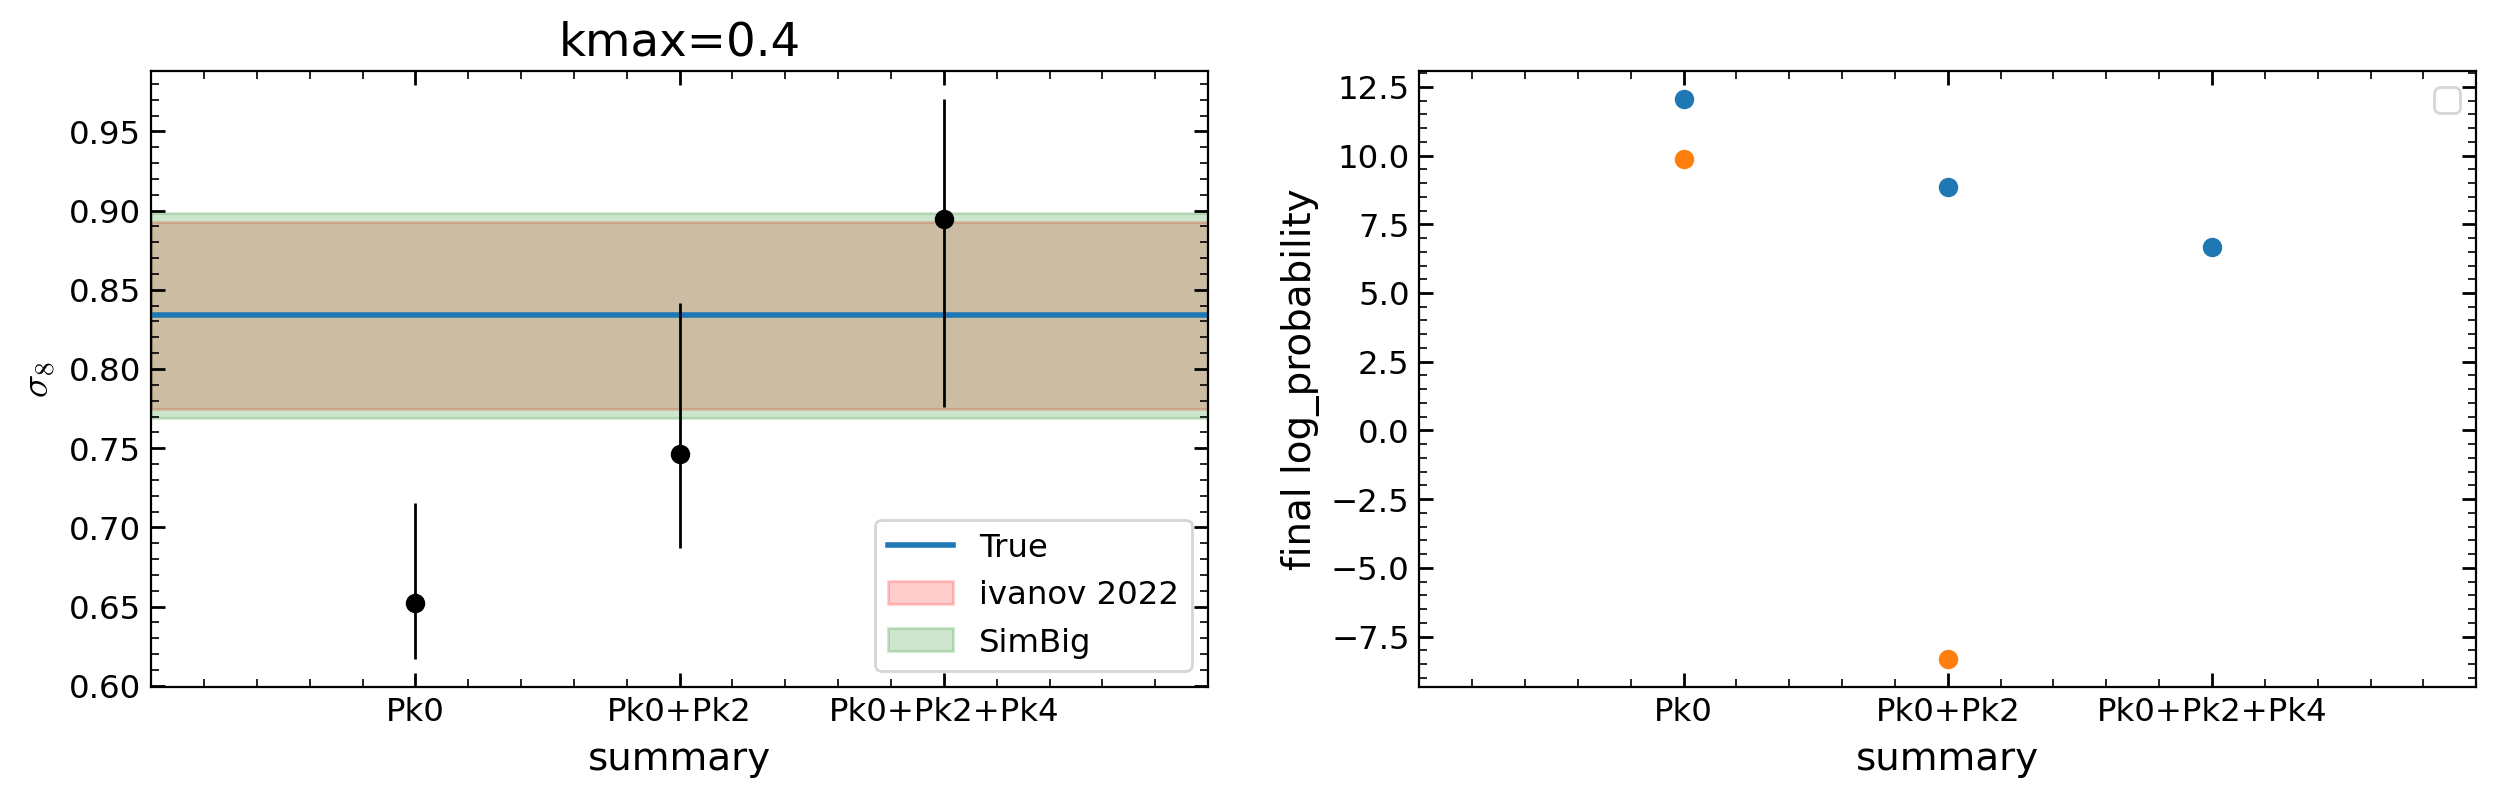

In [77]:
# sigma8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1362it [00:00, 9113.50it/s]            
Drawing 126 posterior samples:  89%|████████▉ | 112/126 [00:00<00:00, 3231.34it/s]
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1707it [00:00, 10855.35it/s]           
Drawing 105 posterior samples: 110it [00:00, 4678.44it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4


INFO:root:Sampling models with [1000, 0] samples each.


(666,)


Drawing 1000 posterior samples: 1709it [00:00, 9988.34it/s]             


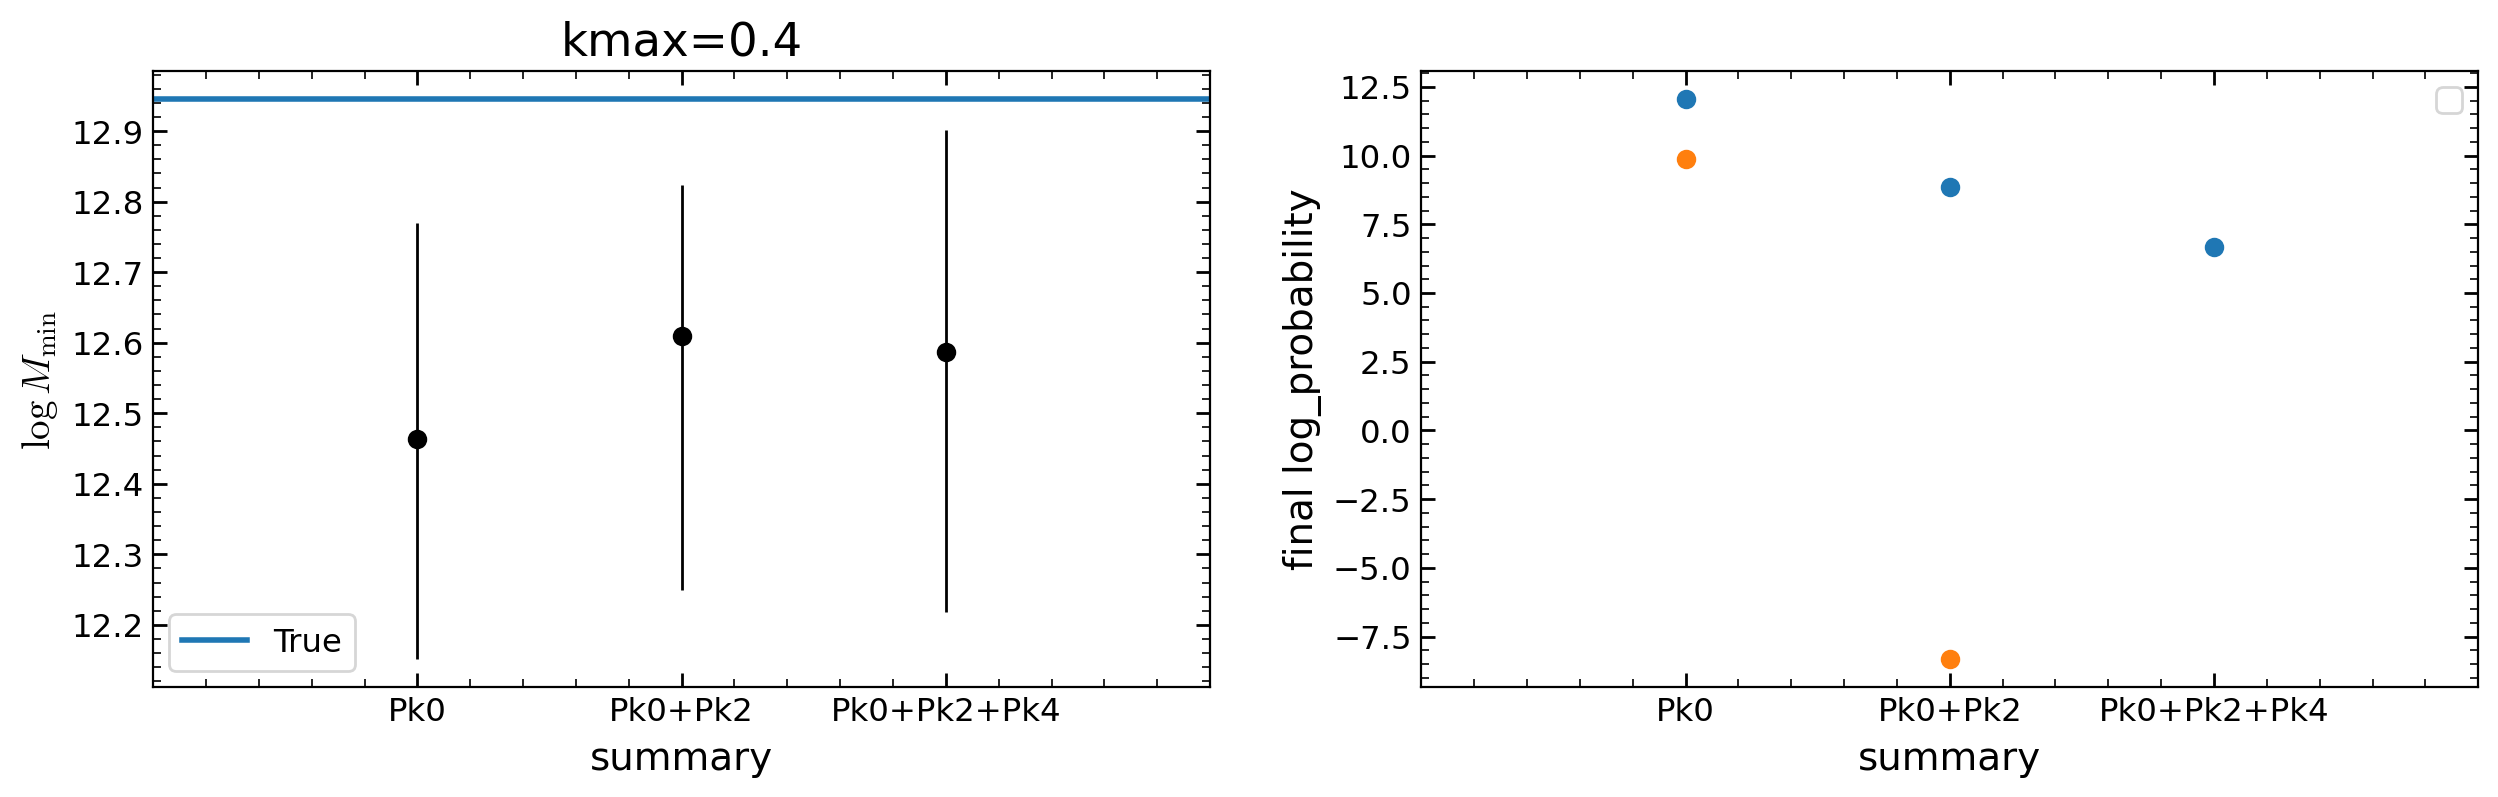

In [80]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

## Check kmax convergence

In [ ]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames+hodnames

# Specify model configuration
nbody = 'mtnglike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

# Specify data dtype
tracer = 'ngc_lightcone'
summaries = ['Pk0', 'Pk2', 'Pk4']
summary = '+'.join(summaries)
kmaxs = np.arange(0.1, 0.6, 0.1)
# os.listdir(modelpath)

Text(0.5, 0.98, 'Stacked posterior residuals')

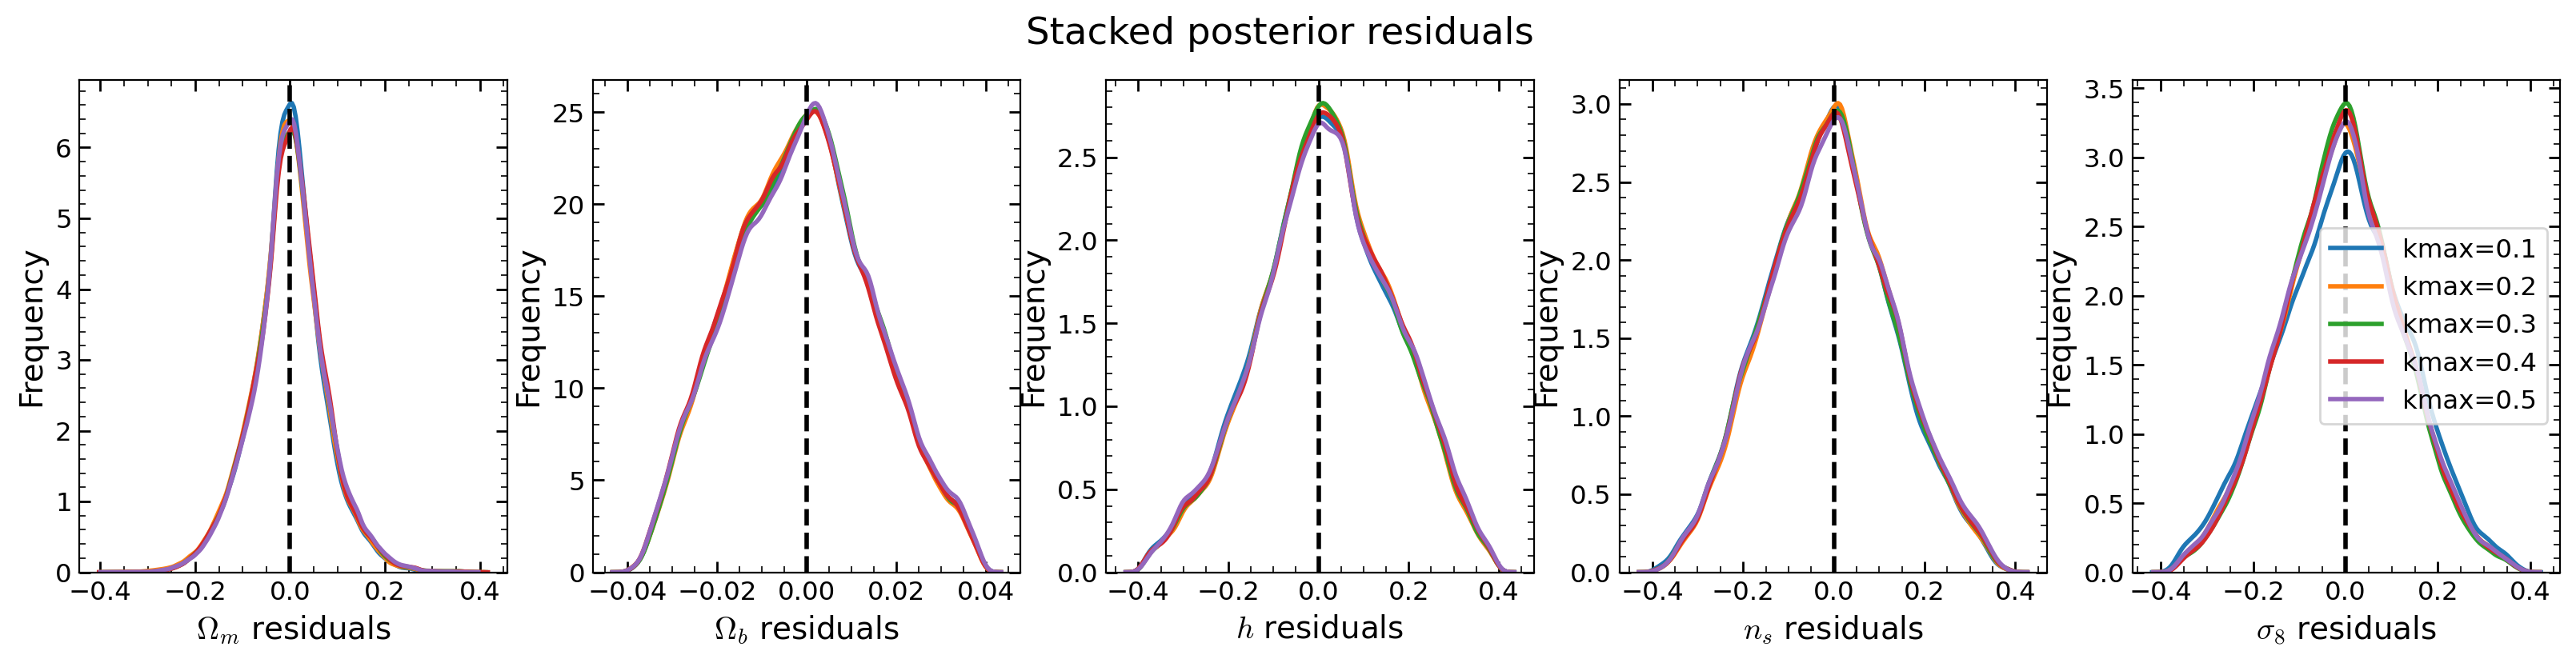

In [23]:
Nparams = 5

f, axs = plt.subplots(1, Nparams, figsize=(20, 4))
for kmax in kmaxs:
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax:.1f}')

    # Load predictions
    xtest = np.load(join(modelpath, 'x_test.npy'))
    ytest = np.load(join(modelpath, 'theta_test.npy'))
    samps = np.load(join(modelpath, 'posterior_samples.npy'))
    percs = np.percentile(samps, [16, 50, 84], axis=0)

    yrange = np.stack([
        ytest.min(axis=0),
        ytest.max(axis=0)
    ], axis=1)

    # plot
    for i, ax in enumerate(axs):
        residuals = samps[..., i] - ytest[None, :, i]
        sns.kdeplot(residuals.flatten(), ax=ax, label=f'kmax={kmax:.1f}', 
                    fill=False)

for i, ax in enumerate(axs):
    ax.axvline(0, color='k', ls='--')
    ax.set(xlabel=f'{names[i]} residuals', ylabel='Frequency')
axs[-1].legend()

f.suptitle('Stacked posterior residuals')

Text(0.5, 0.98, 'Stacked median residuals')

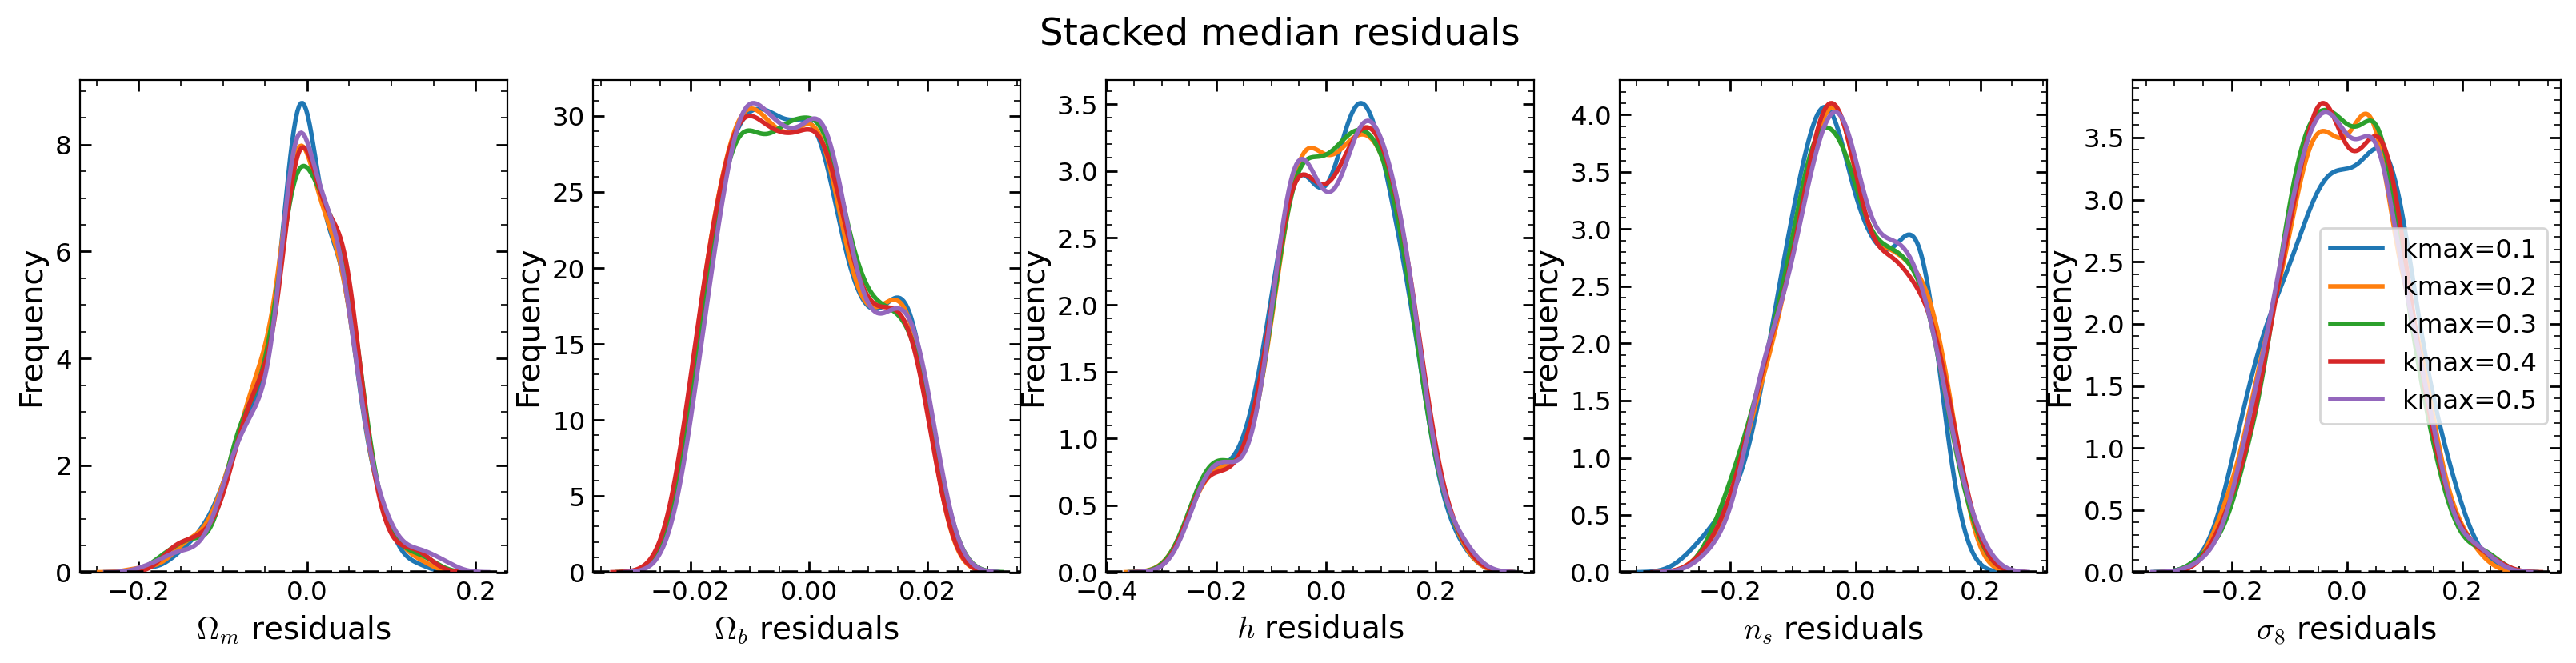

In [24]:
Nparams = 5

f, axs = plt.subplots(1, Nparams, figsize=(20, 4))
for kmax in kmaxs:
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax:.1f}')

    # Load predictions
    xtest = np.load(join(modelpath, 'x_test.npy'))
    ytest = np.load(join(modelpath, 'theta_test.npy'))
    samps = np.load(join(modelpath, 'posterior_samples.npy'))
    percs = np.percentile(samps, [16, 50, 84], axis=0)

    yrange = np.stack([
        ytest.min(axis=0),
        ytest.max(axis=0)
    ], axis=1)

    # plot
    for i, ax in enumerate(axs):
        residuals = percs[1,:,i] - ytest[None, :, i]
        sns.kdeplot(residuals.flatten(), ax=ax, label=f'kmax={kmax:.1f}', fill=False)

for i, ax in enumerate(axs):
    ax.axhline(0, color='k', ls='--')
    ax.set(xlabel=f'{names[i]} residuals', ylabel='Frequency')
axs[-1].legend()
f.suptitle('Stacked median residuals')

In [16]:
samps.shape, ytest.shape, percs.shape

((1000, 380, 10), (380, 10), (3, 380, 10))

## Scratch